In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from transformers import BertTokenizer, BertModel
import torch
torch.cuda.is_available()


c:\Users\avsip\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

## Загрузка данных

In [2]:
features_file = r'C:\ML\28_final_task\D_Online_Retail.xlsx'
df = pd.read_excel(features_file)
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         9   
1    536365     71053                  WHITE METAL LANTERN        10   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         9   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         7   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         9   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55       17850  United Kingdom  
1 2010-12-01 08:26:00       3.39       17850  United Kingdom  
2 2010-12-01 08:26:00       2.75       17850  United Kingdom  
3 2010-12-01 08:26:00       3.39       17850  United Kingdom  
4 2010-12-01 08:26:00       3.39       17850  United Kingdom

## Подготовка данных для катетеризации товаров и предсказания продаж по категориям

In [4]:
## функция очистки значений
def check_descriptions(value):
    if type(value) == str:
        if (len(value) < 2) or '?' in value:
            return "Прочие"
    return value

In [5]:
df['Description'] = df['Description'].map(lambda x: check_descriptions(x))

#### Пред обработка данных, для исключения пропусков и замены пустых значений

In [6]:
import warnings
warnings.filterwarnings("ignore")

df['Description'].fillna('Прочие', inplace=True)
# df['CustomerID'].fillna(-999999, inplace=True)
df['InvoiceNo'].fillna('без номера', inplace=True)
df['Return'] = df['InvoiceNo'].astype(str).str.startswith('C').astype(int)
df['Description'] = df['Description'].str.strip()

df_without_other = df[df['Description'] != 'Прочие']
unique_descriptions = df_without_other[['Description']].drop_duplicates()
unique_descriptions = unique_descriptions.reset_index(drop=True)
print("DataFrame с уникальными товарами:")

DataFrame с уникальными товарами:


In [7]:
len(unique_descriptions)

4186

## Кластеризация товаров для формирования групп товаров

In [8]:
descriptions = unique_descriptions['Description'].tolist()
unique_descriptions['Description'] = unique_descriptions['Description'].astype(str)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
len(descriptions), device

(4186, 'cuda')

использование модели `paraphrase-MiniLM-L6-v2`

In [9]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

models = [
    'paraphrase-MiniLM-L6-v2',
    'all-MiniLM-L6-v2',
    'bert-base-uncased',
    'roberta-base',
    'distilbert-base-uncased'
]

k_values = list(range(2, 11))

best_score = -1
best_model_name = None
best_k = None
best_clusters = None
best_embeddings = None

for model_name in models:
    print(f"Using model: {model_name}")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = SentenceTransformer(model_name, device=device)
    print('device', device)
    embeddings = model.encode(descriptions, show_progress_bar=True, device=device)
    
    scaler = StandardScaler()
    normalized_embeddings = scaler.fit_transform(embeddings)
    
    tsne = TSNE(n_components=2, random_state=0)
    reduced_embeddings = tsne.fit_transform(normalized_embeddings)
    
    for k in k_values:
        print(f"Testing KMeans with k={k}")
        kmeans = KMeans(n_clusters=k, random_state=0)
        clusters = kmeans.fit_predict(normalized_embeddings)

        silhouette_avg = silhouette_score(normalized_embeddings, clusters, metric='cosine') # cosine
        calinski_harabasz = calinski_harabasz_score(normalized_embeddings, clusters)
        davies_bouldin = davies_bouldin_score(normalized_embeddings, clusters)

        print(f'K={k}, Silhouette Score: {silhouette_avg}, Calinski-Harabasz Score: {calinski_harabasz}, Davies-Bouldin Score: {davies_bouldin}')
        
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_model_name = model_name
            best_k = k
            best_clusters = clusters
            best_embeddings = reduced_embeddings



Using model: paraphrase-MiniLM-L6-v2
device cuda


Batches: 100%|██████████| 131/131 [00:01<00:00, 95.88it/s] 


Testing KMeans with k=2
K=2, Silhouette Score: 0.054031044244766235, Calinski-Harabasz Score: 119.6544824863822, Davies-Bouldin Score: 5.870671071959713
Testing KMeans with k=3
K=3, Silhouette Score: 0.05936692655086517, Calinski-Harabasz Score: 115.73255798665555, Davies-Bouldin Score: 5.029848533909589
Testing KMeans with k=4
K=4, Silhouette Score: 0.060654934495687485, Calinski-Harabasz Score: 105.4338364916001, Davies-Bouldin Score: 4.683574448740237
Testing KMeans with k=5
K=5, Silhouette Score: 0.06401477754116058, Calinski-Harabasz Score: 96.67594302815799, Davies-Bouldin Score: 4.459126324921147
Testing KMeans with k=6
K=6, Silhouette Score: 0.06761325150728226, Calinski-Harabasz Score: 93.01433133234406, Davies-Bouldin Score: 4.206347191583515
Testing KMeans with k=7
K=7, Silhouette Score: 0.07458978146314621, Calinski-Harabasz Score: 89.4136914563854, Davies-Bouldin Score: 3.991056320856028
Testing KMeans with k=8
K=8, Silhouette Score: 0.07608991861343384, Calinski-Harabasz 

Batches: 100%|██████████| 131/131 [00:00<00:00, 156.72it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.05198387801647186, Calinski-Harabasz Score: 112.74820401811033, Davies-Bouldin Score: 5.739874082405795
Testing KMeans with k=3
K=3, Silhouette Score: 0.04839610308408737, Calinski-Harabasz Score: 94.53377752773414, Davies-Bouldin Score: 5.786555221596207
Testing KMeans with k=4
K=4, Silhouette Score: 0.051954057067632675, Calinski-Harabasz Score: 85.63584196019404, Davies-Bouldin Score: 5.389660224162474
Testing KMeans with k=5
K=5, Silhouette Score: 0.053254082798957825, Calinski-Harabasz Score: 79.17861703074657, Davies-Bouldin Score: 5.166033710056825
Testing KMeans with k=6
K=6, Silhouette Score: 0.059810493141412735, Calinski-Harabasz Score: 76.1528554588564, Davies-Bouldin Score: 4.824879976595076
Testing KMeans with k=7
K=7, Silhouette Score: 0.06387324631214142, Calinski-Harabasz Score: 72.08395825913587, Davies-Bouldin Score: 4.711581867949552
Testing KMeans with k=8
K=8, Silhouette Score: 0.06687717884778976, Calinski-Harabasz

No sentence-transformers model found with name bert-base-uncased. Creating a new one with mean pooling.


K=10, Silhouette Score: 0.06869956105947495, Calinski-Harabasz Score: 63.0594552476516, Davies-Bouldin Score: 4.2974364807741186
Using model: bert-base-uncased


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

device cuda


Batches: 100%|██████████| 131/131 [00:02<00:00, 57.67it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.08112740516662598, Calinski-Harabasz Score: 188.81613485015933, Davies-Bouldin Score: 4.665770737732477
Testing KMeans with k=3
K=3, Silhouette Score: 0.07301562279462814, Calinski-Harabasz Score: 154.03471766222052, Davies-Bouldin Score: 4.583339511036368
Testing KMeans with k=4
K=4, Silhouette Score: 0.06834179162979126, Calinski-Harabasz Score: 127.97330875122815, Davies-Bouldin Score: 4.501889491581732
Testing KMeans with k=5
K=5, Silhouette Score: 0.07067649066448212, Calinski-Harabasz Score: 115.32021826384728, Davies-Bouldin Score: 4.290506920739949
Testing KMeans with k=6
K=6, Silhouette Score: 0.06715759634971619, Calinski-Harabasz Score: 101.93975891554413, Davies-Bouldin Score: 4.223181507156182
Testing KMeans with k=7
K=7, Silhouette Score: 0.05651898309588432, Calinski-Harabasz Score: 93.11091532301057, Davies-Bouldin Score: 4.304449645626762
Testing KMeans with k=8
K=8, Silhouette Score: 0.06238424405455589, Calinski-Haraba

No sentence-transformers model found with name roberta-base. Creating a new one with mean pooling.


K=10, Silhouette Score: 0.058419644832611084, Calinski-Harabasz Score: 75.81808686569764, Davies-Bouldin Score: 4.181168093000723
Using model: roberta-base


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


device cuda


Batches: 100%|██████████| 131/131 [00:02<00:00, 46.31it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.06121441349387169, Calinski-Harabasz Score: 139.72589727877977, Davies-Bouldin Score: 5.394788283082473
Testing KMeans with k=3
K=3, Silhouette Score: 0.04503694549202919, Calinski-Harabasz Score: 146.839110900055, Davies-Bouldin Score: 4.384003629715679
Testing KMeans with k=4
K=4, Silhouette Score: 0.05106807500123978, Calinski-Harabasz Score: 126.28294888459936, Davies-Bouldin Score: 4.523683858750046
Testing KMeans with k=5
K=5, Silhouette Score: 0.052409376949071884, Calinski-Harabasz Score: 112.15976800440096, Davies-Bouldin Score: 4.466785752115174
Testing KMeans with k=6
K=6, Silhouette Score: 0.05639660730957985, Calinski-Harabasz Score: 106.52957384329233, Davies-Bouldin Score: 4.196755685341963
Testing KMeans with k=7
K=7, Silhouette Score: 0.05708536133170128, Calinski-Harabasz Score: 95.7566473998984, Davies-Bouldin Score: 4.3381454243008095
Testing KMeans with k=8
K=8, Silhouette Score: 0.060547836124897, Calinski-Harabasz 

No sentence-transformers model found with name distilbert-base-uncased. Creating a new one with mean pooling.


device cuda


Batches: 100%|██████████| 131/131 [00:01<00:00, 97.32it/s] 


Testing KMeans with k=2
K=2, Silhouette Score: 0.0709916278719902, Calinski-Harabasz Score: 160.86821425028845, Davies-Bouldin Score: 4.969118591891541
Testing KMeans with k=3
K=3, Silhouette Score: 0.07153258472681046, Calinski-Harabasz Score: 146.6010888651486, Davies-Bouldin Score: 4.37897456440366
Testing KMeans with k=4
K=4, Silhouette Score: 0.06994958221912384, Calinski-Harabasz Score: 131.20304581795162, Davies-Bouldin Score: 4.069884280899016
Testing KMeans with k=5
K=5, Silhouette Score: 0.07466502487659454, Calinski-Harabasz Score: 123.5464017636579, Davies-Bouldin Score: 3.908310600214341
Testing KMeans with k=6
K=6, Silhouette Score: 0.07346051931381226, Calinski-Harabasz Score: 110.15268225917713, Davies-Bouldin Score: 3.845830022484814
Testing KMeans with k=7
K=7, Silhouette Score: 0.07538436353206635, Calinski-Harabasz Score: 103.59121697577486, Davies-Bouldin Score: 3.7593439104492004
Testing KMeans with k=8
K=8, Silhouette Score: 0.062245726585388184, Calinski-Harabas

In [13]:
print(f'Best model: {best_model_name}')
print(f'Best number of clusters (K): {best_k}')
print(f'Best Silhouette Score: {best_score}')


Best model: paraphrase-MiniLM-L6-v2
Best number of clusters (K): 9
Best Silhouette Score: 0.08163392543792725


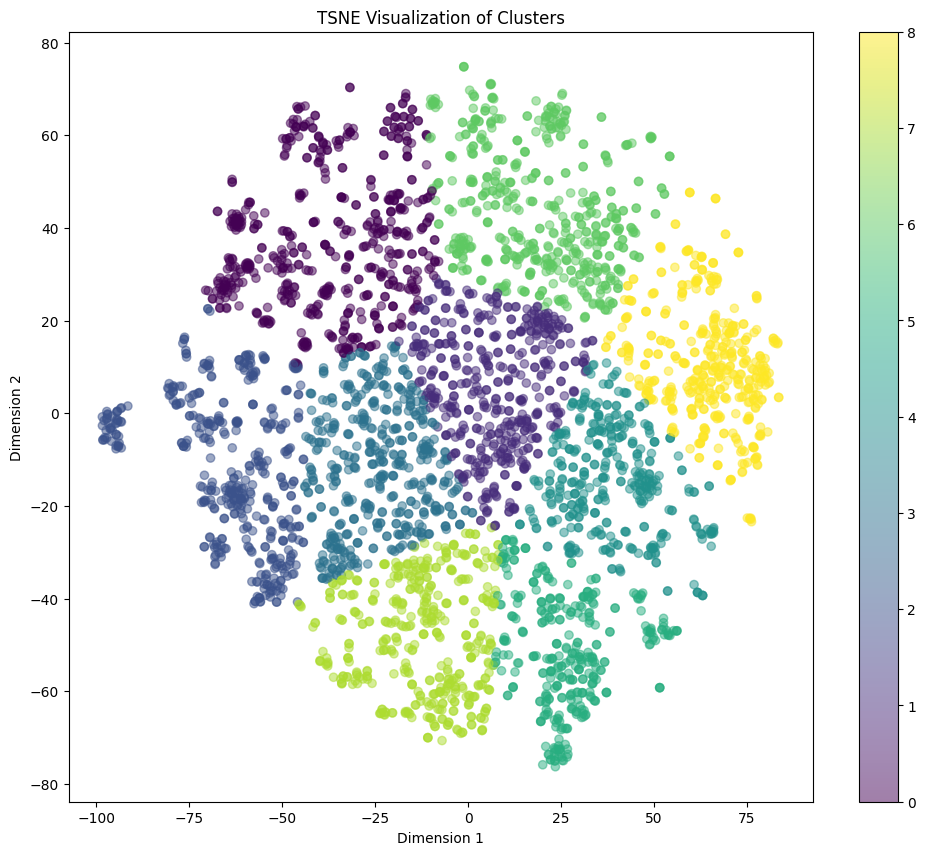

In [17]:

kmeans = KMeans(n_clusters=best_k, random_state=0)
clusters_4 = kmeans.fit_predict(best_embeddings)

unique_descriptions['clusters_4'] = clusters_4

plt.figure(figsize=(12, 10))
scatter = plt.scatter(best_embeddings[:, 0], best_embeddings[:, 1], c=clusters_4, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.title('TSNE Visualization of Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [18]:
cluster_distribution = unique_descriptions['clusters_4'].value_counts()
print("Cluster distribution:")
cluster_distribution

Cluster distribution:


clusters_4
0    573
6    547
1    494
3    491
8    449
7    442
2    441
4    388
5    361
Name: count, dtype: int64

In [19]:
for cluster_num in set(clusters_4):
    if cluster_num != -1:
        cluster_df = unique_descriptions[unique_descriptions['clusters_4'] == cluster_num]['Description'].value_counts()
        top_items = cluster_df[15:25]
        print(f"Cluster {cluster_num}:")
        print(top_items.index.tolist())
        # print("\n")

Cluster 0:
['Display', 'CROCHET WHITE RABBIT KEYRING', 'CROCHET BEAR RED/BLUE  KEYRING', 'IVORY WIRE KITCHEN ORGANISER', 'Thrown away.', 'BUFFALO BILL TREASURE BOOK BOX', 'GYMKHANNA TREASURE BOOK BOX', 'ABC TREASURE BOOK BOX', 'PANTRY PASTRY BRUSH', 'GYMKHANA TREASURE BOOK BOX']
Cluster 1:
['SET OF 6 HERB TINS SKETCHBOOK', 'ANTIQUE GLASS PLACE SETTING', 'DANISH ROSE BEDSIDE CABINET', 'PINK  HONEYCOMB PAPER FAN', 'CHARLIE & LOLA WASTEPAPER BIN BLUE', 'GOLD SCROLL GLASS T-LIGHT HOLDER', 'ECONOMY HOLIDAY PURSE', 'VIP HOLIDAY PURSE', 'TROPICAL HOLIDAY PURSE', 'BLOSSOM IMAGES GIFT WRAP SET']
Cluster 2:
['sold as set on dotcom and amazon', 'sold as set on dotcom', 'FOLKART CHRISTMAS TREE T-LIGHT HOLD', '36 DOILIES VINTAGE CHRISTMAS', 'reverse previous adjustment', 'incorrectly credited C550456 see 47', 'on cargo order', 'sold as set/6 by dotcom', 'Not rcvd in 10/11/2010 delivery', 'mailout']
Cluster 3:
['TEA TIME TEAPOT IN GIFT BOX', 'ENAMEL PINK TEA CONTAINER', 'SET OF 16 VINTAGE RED CUTLER

<!-- 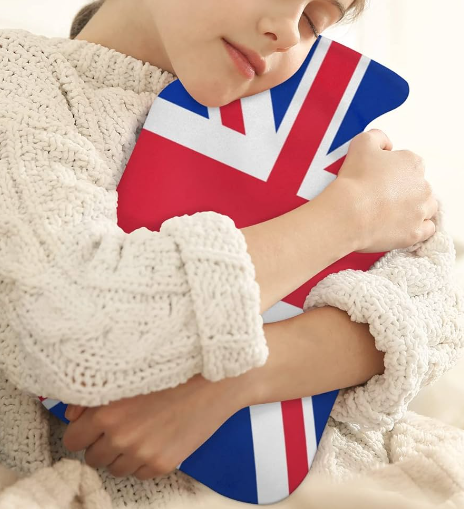 *Подпись к фото 1*  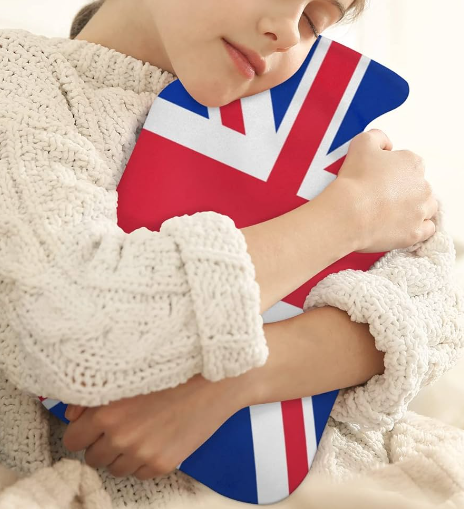 *Подпись к фото 1* -->


In [20]:
category_name = {
    0: '1. Стилизованные вещи интерьера с уникальным дизайном',
    1: '2. Стеклянные и керамические аксессуары (оформление интерьера)',
    2: '3. Часы и рождественские украшения',
    3: '4. Кухонные аксессуары и посуда',
    4: '5. Игрушки или детские товары',
    5: '6. Свечи и освещение',
    6: '7. Декор для дома',
    7: '8. Праздничные украшения',
    8: '9. Браслеты бижутерия',
}


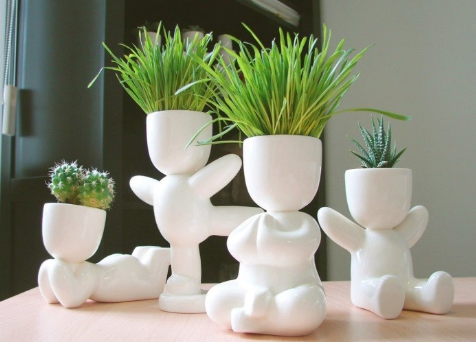  <br>
<p>1. Стилизованные вещи интерьера с уникальным дизайном</p>

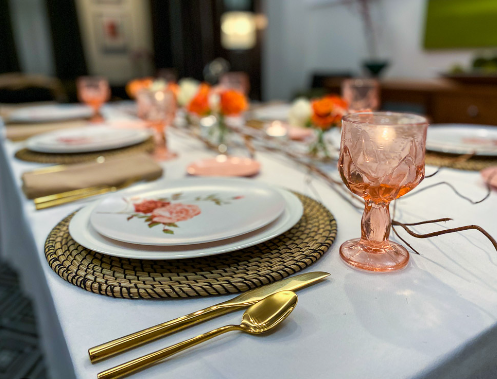  <br>
<p>2. Стеклянные и керамические аксессуары (оформление интерьера)</p>

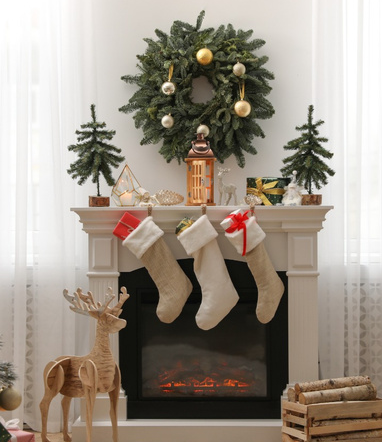  <br>
<p>3. Часы и рождественские украшения</p> 

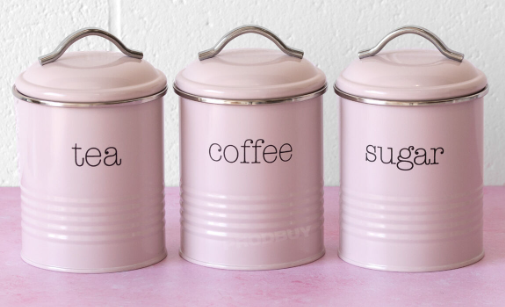  <br>
<p>4. Кухонные аксессуары и посуда</p> 

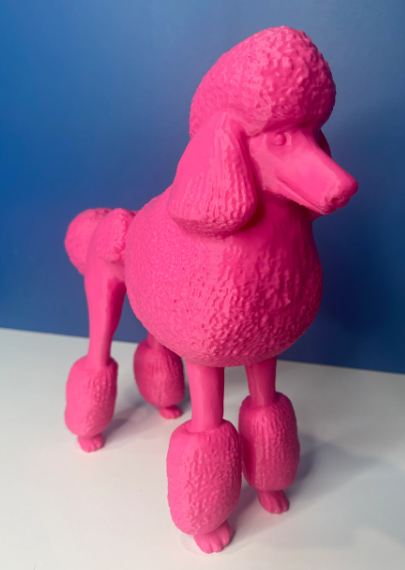  <br>
<p>5. Игрушки или детские товары</p> 

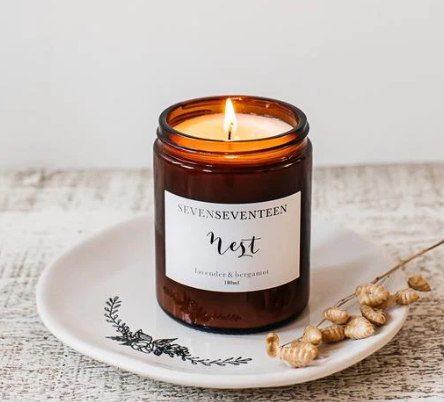  <br>
<p>6. Свечи и освещение</p>

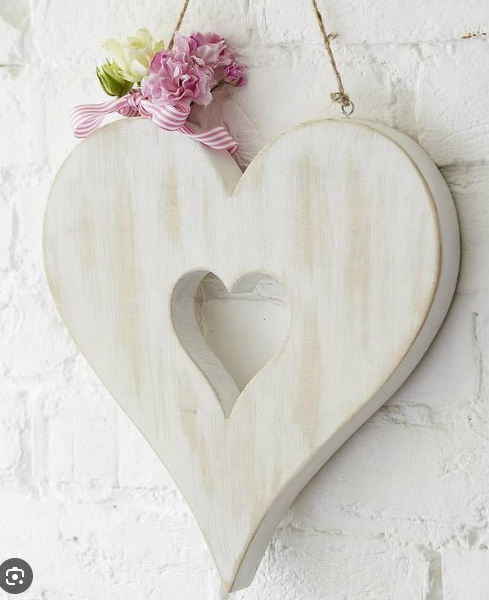  <br>
<p>7. Декор для дома</p>

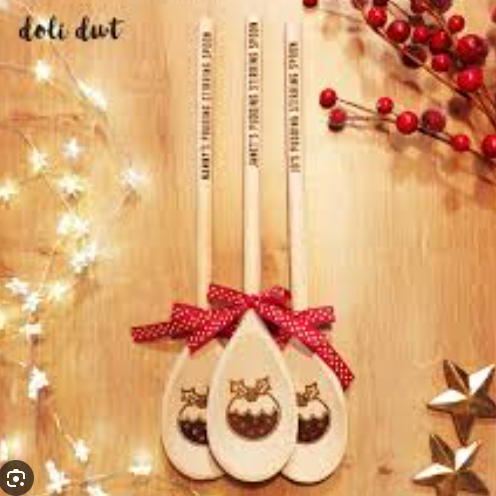  <br>
<p>8. Праздничные украшения</p> 

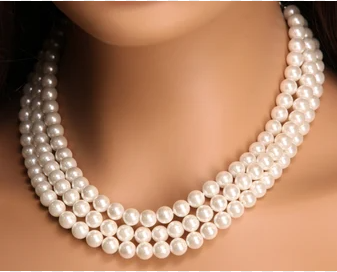  <br>
<p>9. Браслеты</p> 

In [21]:
unique_descriptions['category_name'] = unique_descriptions.clusters_4.apply(lambda x : category_name.get(x, 'other'))

In [22]:
unique_descriptions[15:25]

Description  clusters_4  \
15    BOX OF VINTAGE JIGSAW BLOCKS           0   
16  BOX OF VINTAGE ALPHABET BLOCKS           0   
17        HOME BUILDING BLOCK WORD           0   
18        LOVE BUILDING BLOCK WORD           0   
19     RECIPE BOX WITH METAL HEART           6   
20             DOORMAT NEW ENGLAND           0   
21        JAM MAKING SET WITH JARS           3   
22     RED COAT RACK PARIS FASHION           8   
23  YELLOW COAT RACK PARIS FASHION           8   
24    BLUE COAT RACK PARIS FASHION           8   

                                        category_name  
15  1. Стилизованные вещи интерьера с уникальным д...  
16  1. Стилизованные вещи интерьера с уникальным д...  
17  1. Стилизованные вещи интерьера с уникальным д...  
18  1. Стилизованные вещи интерьера с уникальным д...  
19                                  7. Декор для дома  
20  1. Стилизованные вещи интерьера с уникальным д...  
21                    4. Кухонные аксессуары и посуда  
22                              9. Браслеты бижутерия  
23                              9. Браслеты бижутерия  
24                              9. Браслеты бижутерия

перевод 50 товарных позиций для каждой категории для оценки семантического сходства товарных позиций в категориях (25-30% от общего кол. в каждой категории)

## Подготовка данных для анализа временных рядов и предсказания продаж

In [23]:
df_with_category = df.merge(unique_descriptions, how='left')
df_with_category['category_name'].fillna('11. Прочие', inplace=True)
df_with_category['clusters_4'].fillna('11', inplace=True)
# Добавление столбца с номером недели года и месяца
df_with_category['Week'] = df_with_category['InvoiceDate'].dt.isocalendar().week
df_with_category['Month'] = df_with_category['InvoiceDate'].dt.month
df_with_category['Year'] = df_with_category['InvoiceDate'].dt.year

In [24]:
df_with_category

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         9   
1         536365     71053                  WHITE METAL LANTERN        10   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         9   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         7   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         9   
...          ...       ...                                  ...       ...   
966418    581019    84251G     GREETING CARD, OVERCROWDED POOL.         6   
966419    581439    17084P                DRAGONS BLOOD INCENSE         9   
966420    580744     22899          CHILDREN'S APRON DOLLY GIRL        23   
966421    580730     21288      STRIPEY CHOCOLATE NESTING BOXES         6   
966422    580730     21137             BLACK RECORD COVER FRAME         8   

               InvoiceDate  UnitPrice  CustomerID         Country  Return  \
0      2010-12-01 08:26:00       2.55       17850  United Kingdom       0   
1      2010-12-01 08:26:00       3.39       17850  United Kingdom       0   
2      2010-12-01 08:26:00       2.75       17850  United Kingdom       0   
3      2010-12-01 08:26:00       3.39       17850  United Kingdom       0   
4      2010-12-01 08:26:00       3.39       17850  United Kingdom       0   
...                    ...        ...         ...             ...     ...   
966418 2012-12-07 10:11:00       0.19       14794  United Kingdom       0   
966419 2012-12-08 16:30:00       0.42     -999999  United Kingdom       0   
966420 2012-12-06 09:31:00       1.85       13694  United Kingdom       0   
966421 2012-12-05 17:28:00       3.29     -999999  United Kingdom       0   
966422 2012-12-05 17:28:00       4.13     -999999  United Kingdom       0   

       clusters_4                       category_name  Week  Month  Year  
0             6.0                   7. Декор для дома    48     12  2010  
1             5.0                6. Свечи и освещение    48     12  2010  
2             6.0                   7. Декор для дома    48     12  2010  
3             6.0                   7. Декор для дома    48     12  2010  
4             6.0                   7. Декор для дома    48     12  2010  
...           ...                                 ...   ...    ...   ...  
966418        2.0  3. Часы и рождественские украшения    49     12  2012  
966419        5.0                6. Свечи и освещение    49     12  2012  
966420        7.0            8. Праздничные украшения    49     12  2012  
966421        7.0            8. Праздничные украшения    49     12  2012  
966422        6.0                   7. Декор для дома    49     12  2012  

[966423 rows x 14 columns]

## Аналитика временных рядов продаж категорий товаров

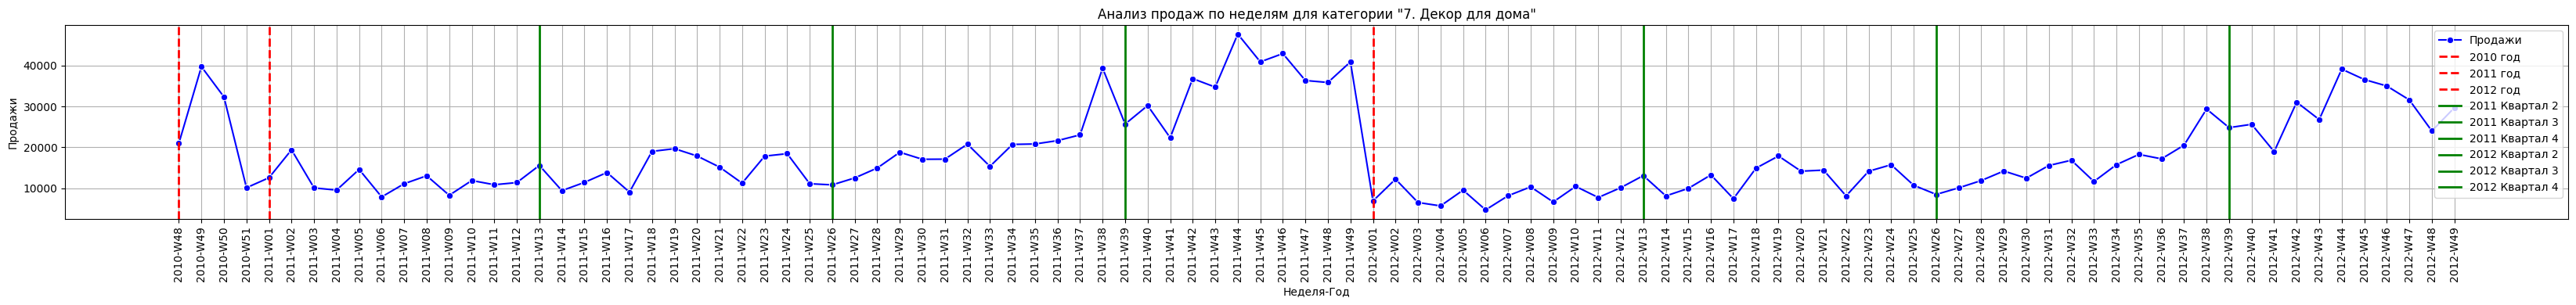

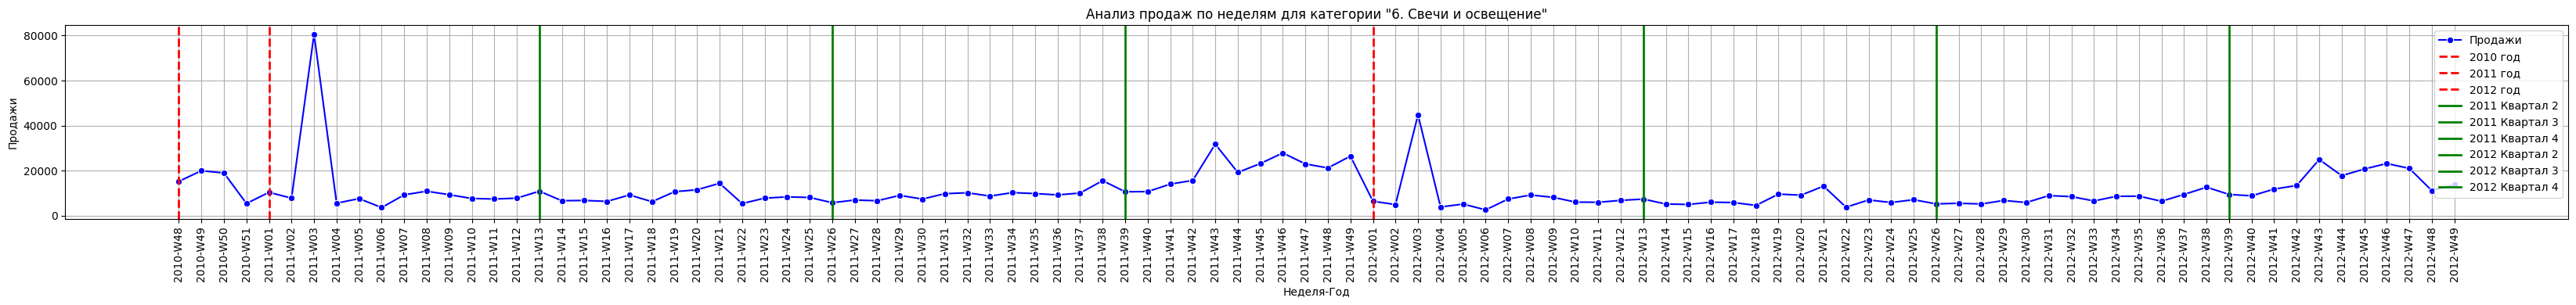

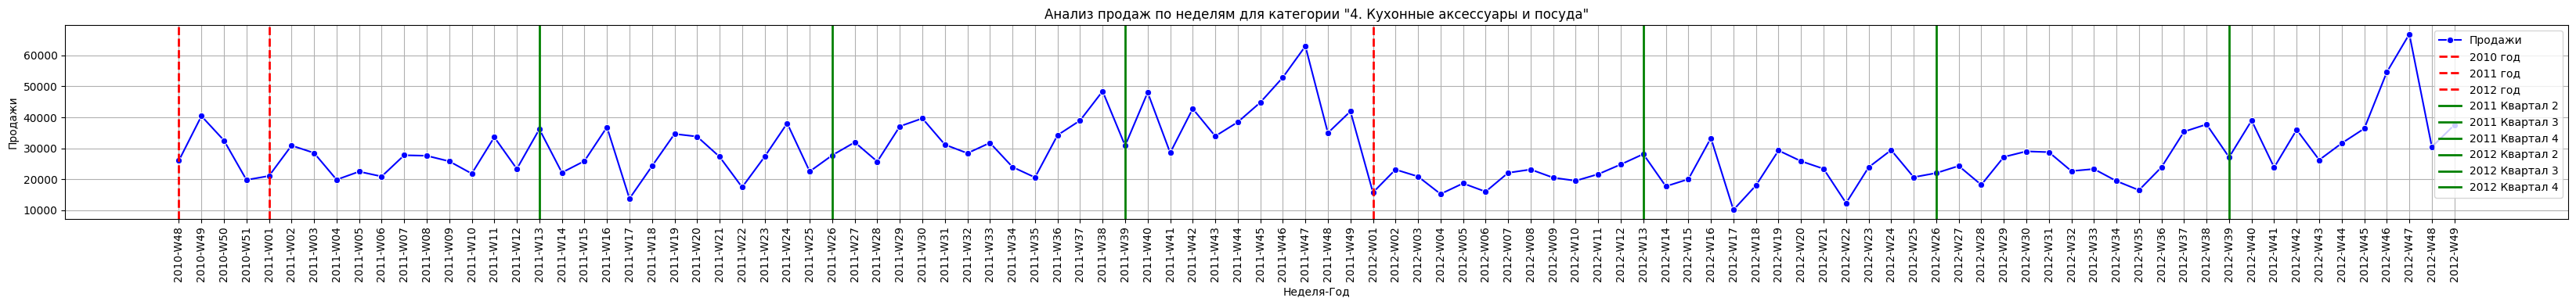

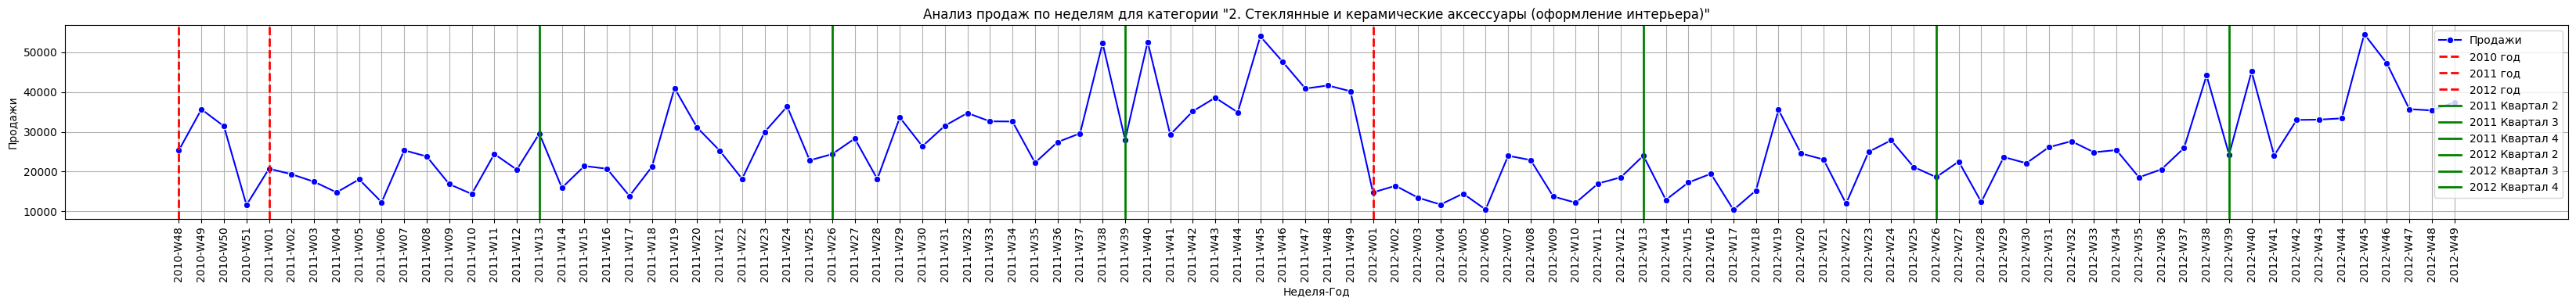

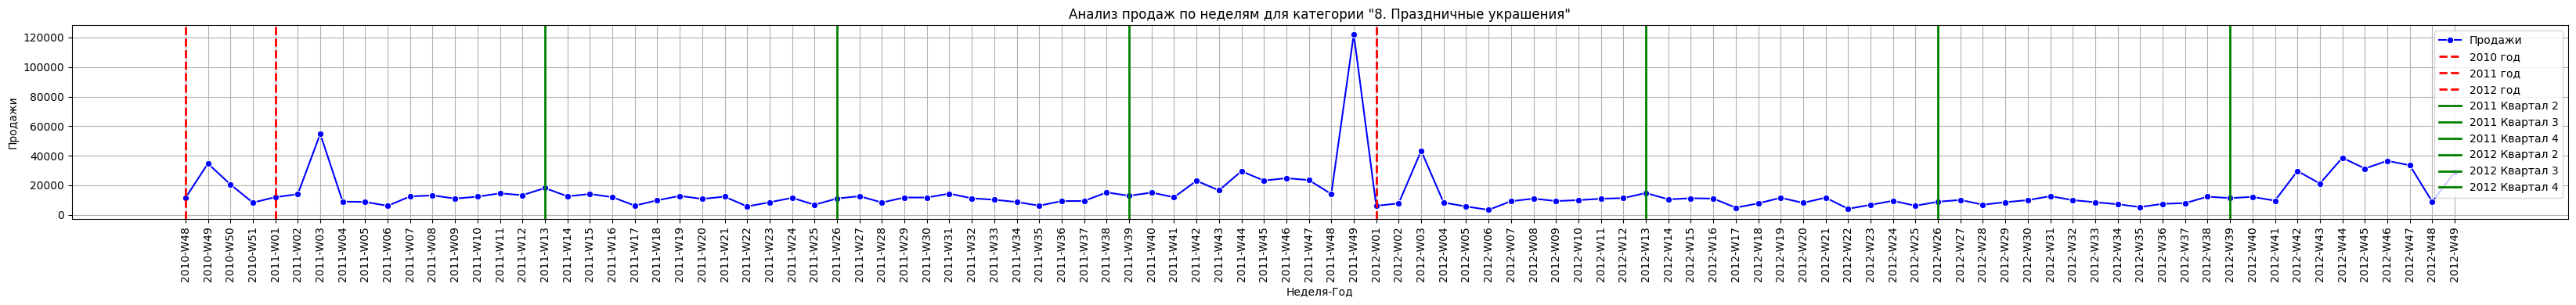

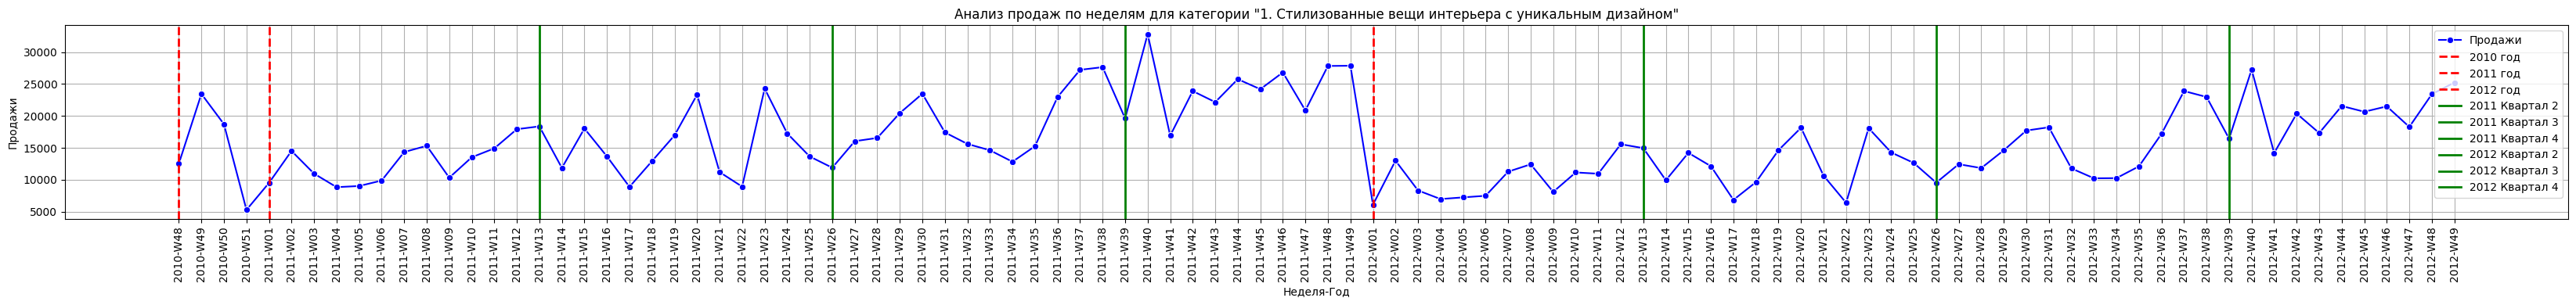

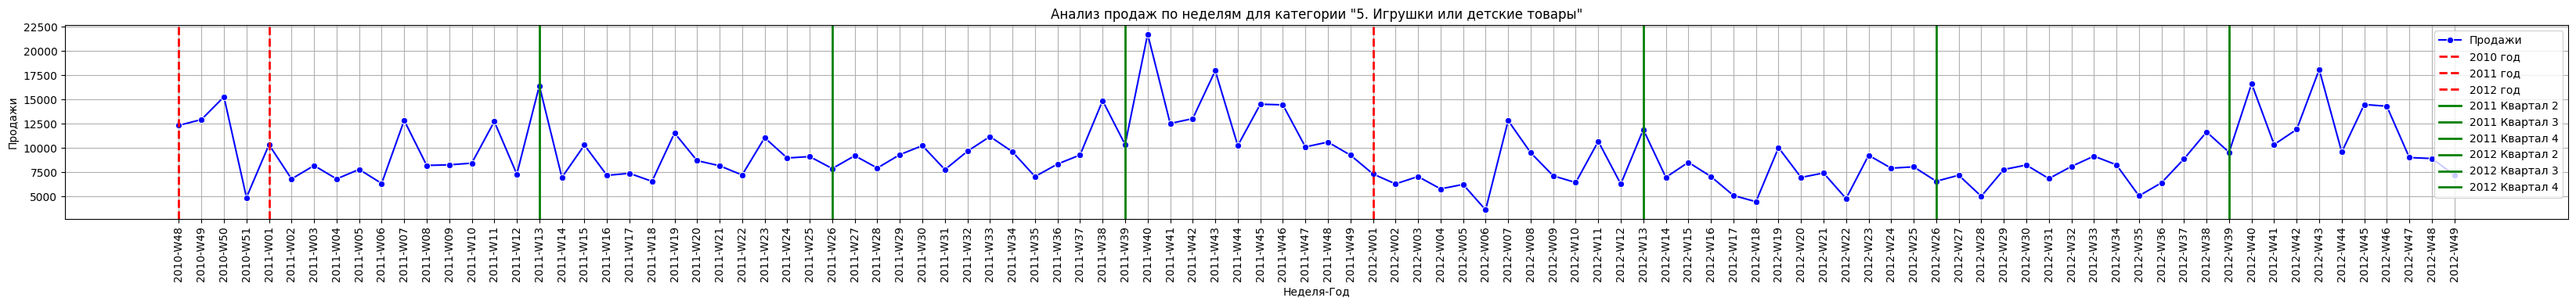

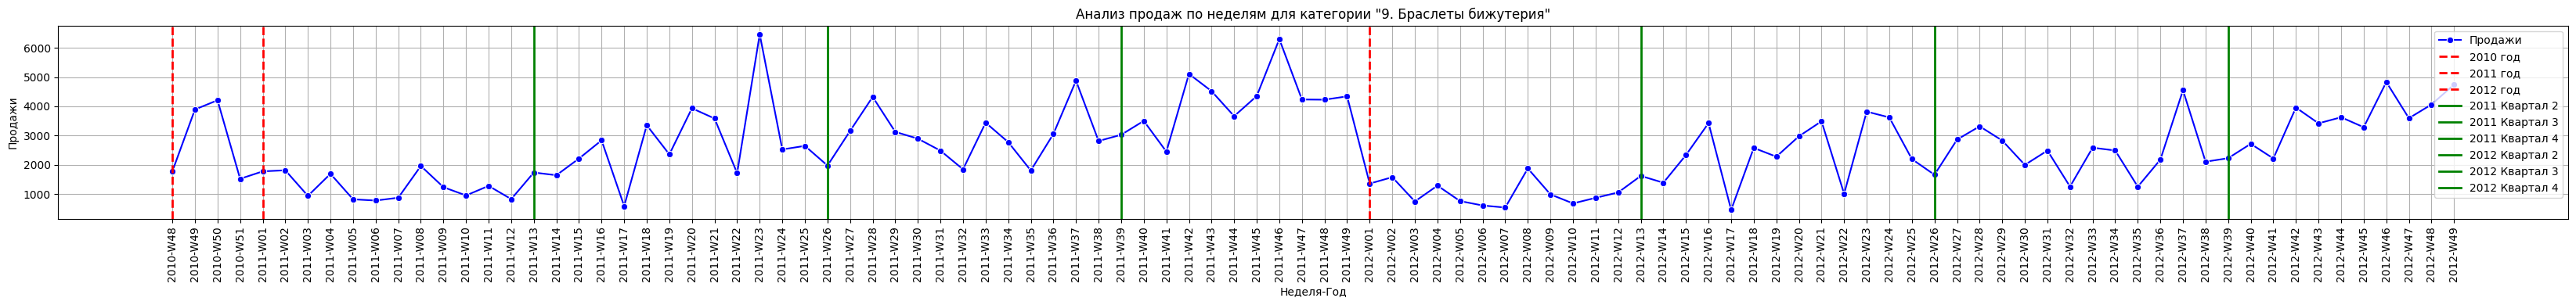

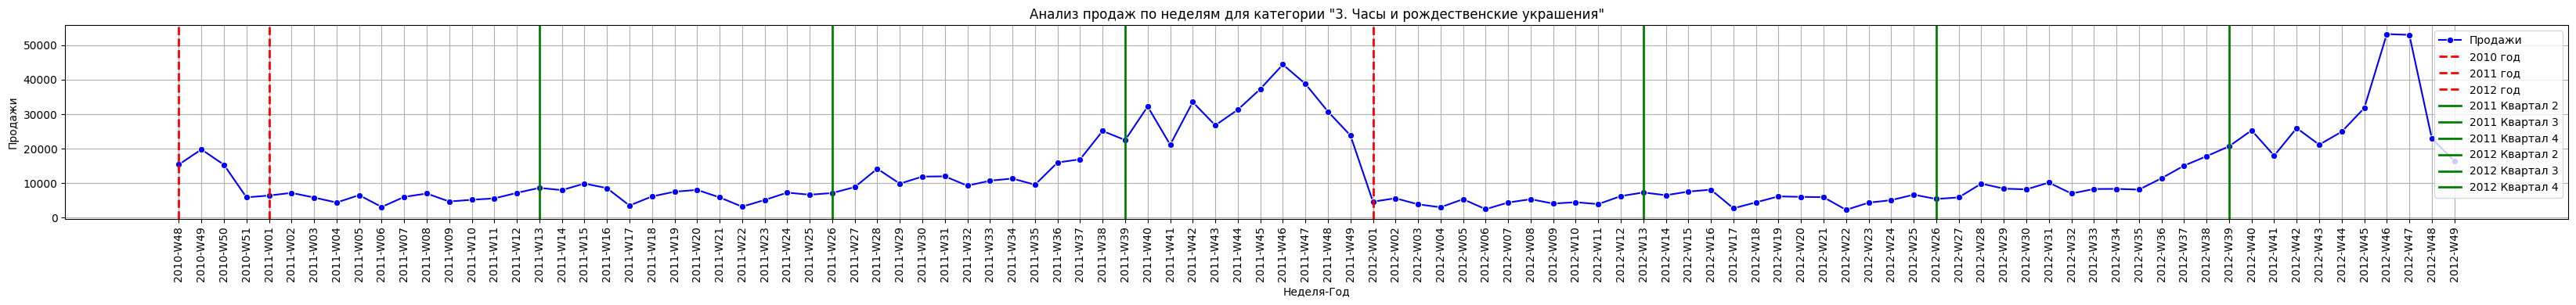

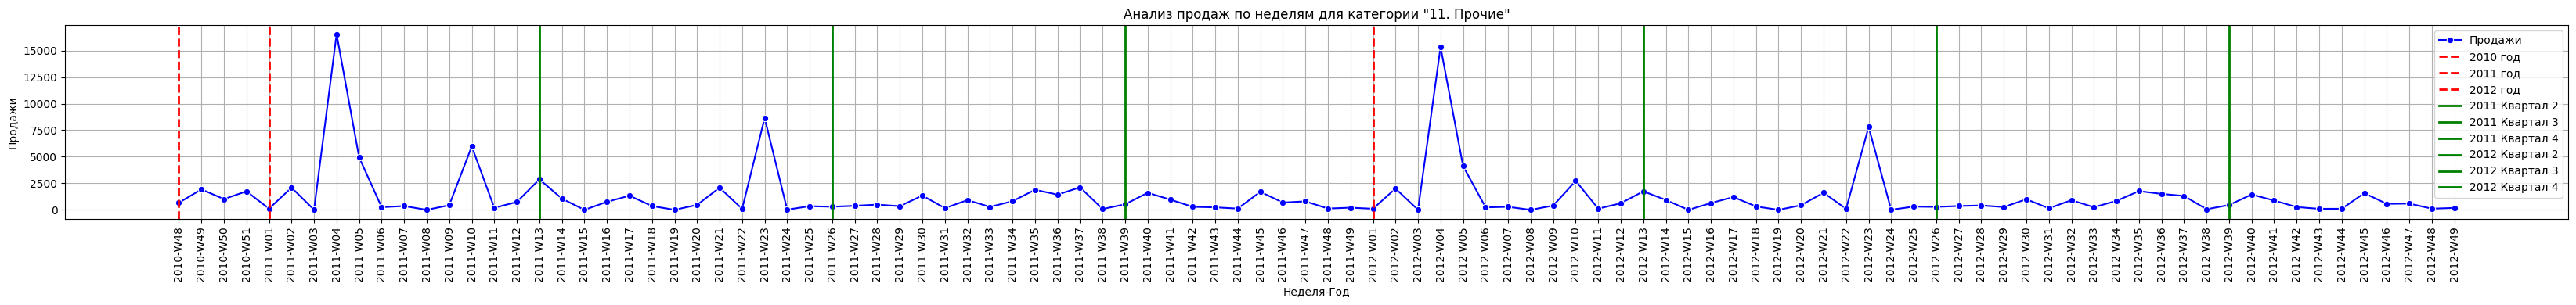

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_category_sales(df, category_name):
    # Фильтруем данные по выбранной категории
    data_category = df[df['category_name'] == category_name]
    
    # Группировка данных по неделям и годам
    sales_by_week_year = data_category.groupby(['Year', 'Week'])['Quantity'].sum().reset_index()
    
    # Создание новой колонки для отображения в формате 'Year-Week'
    sales_by_week_year['Year_Week'] = sales_by_week_year.apply(
        lambda row: f"{int(row['Year'])}-W{int(row['Week']):02d}", axis=1
    )
    
    # Создаем фигуру и оси
    fig, ax = plt.subplots(figsize=(33, 4))
    
    # Строим график сезонности продаж по неделям и годам
    sns.lineplot(x='Year_Week', y='Quantity', data=sales_by_week_year, marker='o', ax=ax, label='Продажи', color='blue')
    
    # Настройка формата оси X
    ax.set_title(f'Анализ продаж по неделям для категории "{category_name}"')
    ax.set_xlabel('Неделя-Год')
    ax.set_ylabel('Продажи')
    
    # Настройка формата оси X для отображения всех недель
    ax.set_xticks(sales_by_week_year['Year_Week'])  # Устанавливаем все недели как метки
    ax.set_xticklabels(sales_by_week_year['Year_Week'], rotation=90)  # Поворачиваем метки для удобства чтения

    # Добавляем линии для разделения годов
    years = sales_by_week_year['Year'].unique()
    for year in years:
        year_label = f"{int(year)}"
        year_weeks = sales_by_week_year[sales_by_week_year['Year'] == year]['Year_Week']
        # Отмечаем начало каждого года вертикальной линией
        ax.axvline(x=year_weeks.iloc[0], color='red', linestyle='--', linewidth=2, label=f'{year} год')

    # Добавляем линии для разделения кварталов
    for year in years:
        quarters = [13, 26, 39, 52]  # Начало каждого квартала
        for week in quarters:
            week_label = f"{int(year)}-W{week:02d}"
            if week_label in sales_by_week_year['Year_Week'].values:
                ax.axvline(x=week_label, color='green', linestyle='-', linewidth=2, label=f'{year} Квартал {week//13 + 1}')
    
    # Удаляем дублирующиеся записи в легенде
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    # Включение сетки
    ax.grid(True)
    
    # Показываем график
    plt.tight_layout()
    plt.show()

# Вызов функции для каждой категории
categories = df_with_category['category_name'].unique()
for category in categories:
    plot_category_sales(df_with_category, category)


In [26]:
df_with_category

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         9   
1         536365     71053                  WHITE METAL LANTERN        10   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         9   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         7   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         9   
...          ...       ...                                  ...       ...   
966418    581019    84251G     GREETING CARD, OVERCROWDED POOL.         6   
966419    581439    17084P                DRAGONS BLOOD INCENSE         9   
966420    580744     22899          CHILDREN'S APRON DOLLY GIRL        23   
966421    580730     21288      STRIPEY CHOCOLATE NESTING BOXES         6   
966422    580730     21137             BLACK RECORD COVER FRAME         8   

               InvoiceDate  UnitPrice  CustomerID         Country  Return  \
0      2010-12-01 08:26:00       2.55       17850  United Kingdom       0   
1      2010-12-01 08:26:00       3.39       17850  United Kingdom       0   
2      2010-12-01 08:26:00       2.75       17850  United Kingdom       0   
3      2010-12-01 08:26:00       3.39       17850  United Kingdom       0   
4      2010-12-01 08:26:00       3.39       17850  United Kingdom       0   
...                    ...        ...         ...             ...     ...   
966418 2012-12-07 10:11:00       0.19       14794  United Kingdom       0   
966419 2012-12-08 16:30:00       0.42     -999999  United Kingdom       0   
966420 2012-12-06 09:31:00       1.85       13694  United Kingdom       0   
966421 2012-12-05 17:28:00       3.29     -999999  United Kingdom       0   
966422 2012-12-05 17:28:00       4.13     -999999  United Kingdom       0   

       clusters_4                       category_name  Week  Month  Year  
0             6.0                   7. Декор для дома    48     12  2010  
1             5.0                6. Свечи и освещение    48     12  2010  
2             6.0                   7. Декор для дома    48     12  2010  
3             6.0                   7. Декор для дома    48     12  2010  
4             6.0                   7. Декор для дома    48     12  2010  
...           ...                                 ...   ...    ...   ...  
966418        2.0  3. Часы и рождественские украшения    49     12  2012  
966419        5.0                6. Свечи и освещение    49     12  2012  
966420        7.0            8. Праздничные украшения    49     12  2012  
966421        7.0            8. Праздничные украшения    49     12  2012  
966422        6.0                   7. Декор для дома    49     12  2012  

[966423 rows x 14 columns]

Importing plotly failed. Interactive plots will not work.




Категория: 7. Декор для дома


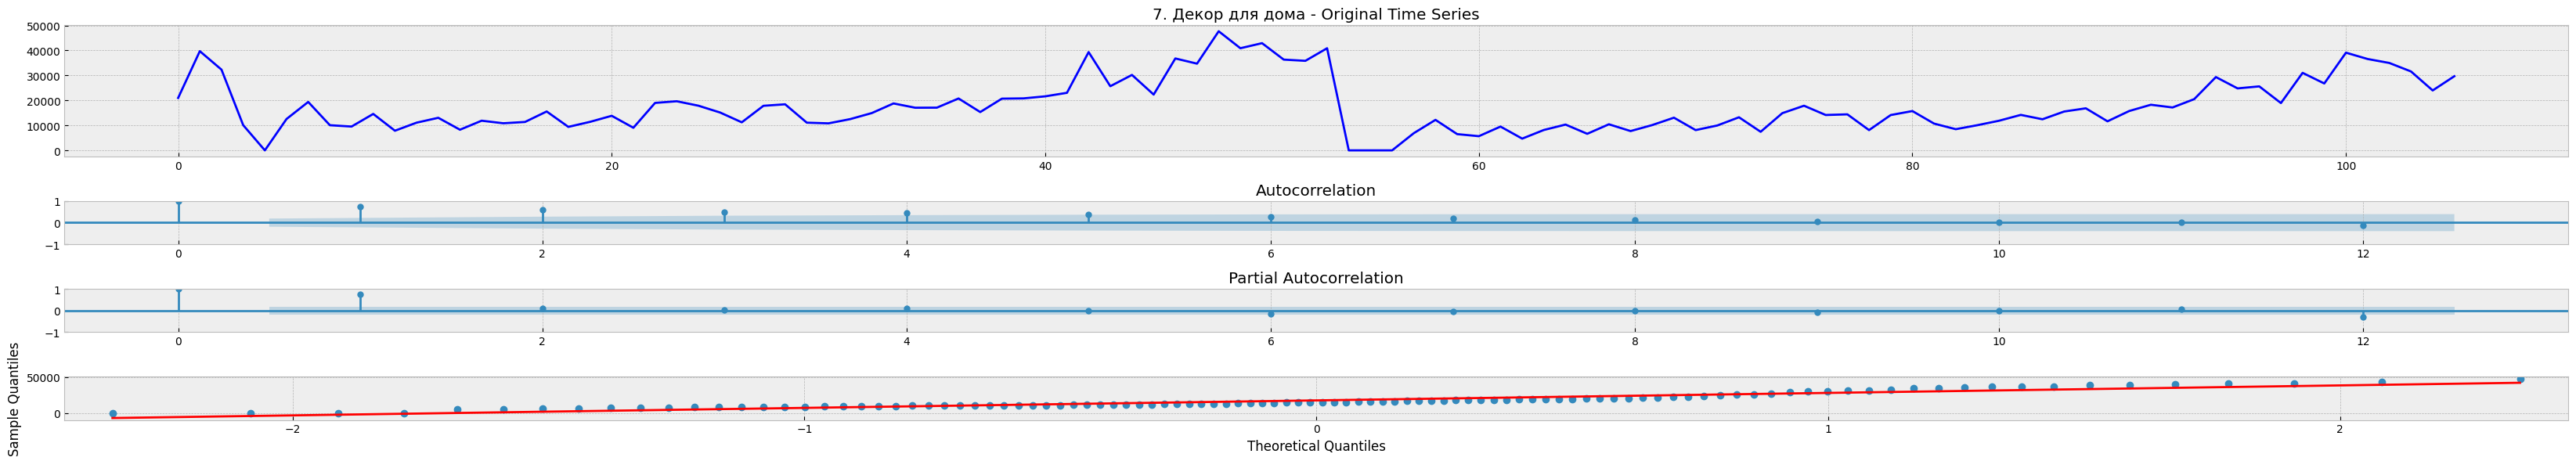

02:33:37 - cmdstanpy - INFO - Chain [1] start processing
02:33:38 - cmdstanpy - INFO - Chain [1] done processing


Категория - 7. Декор для дома
Лучший MSE: 11350537.71080, MAE: 2676.23406, R²: 0.83396, MAPE: 12.22%


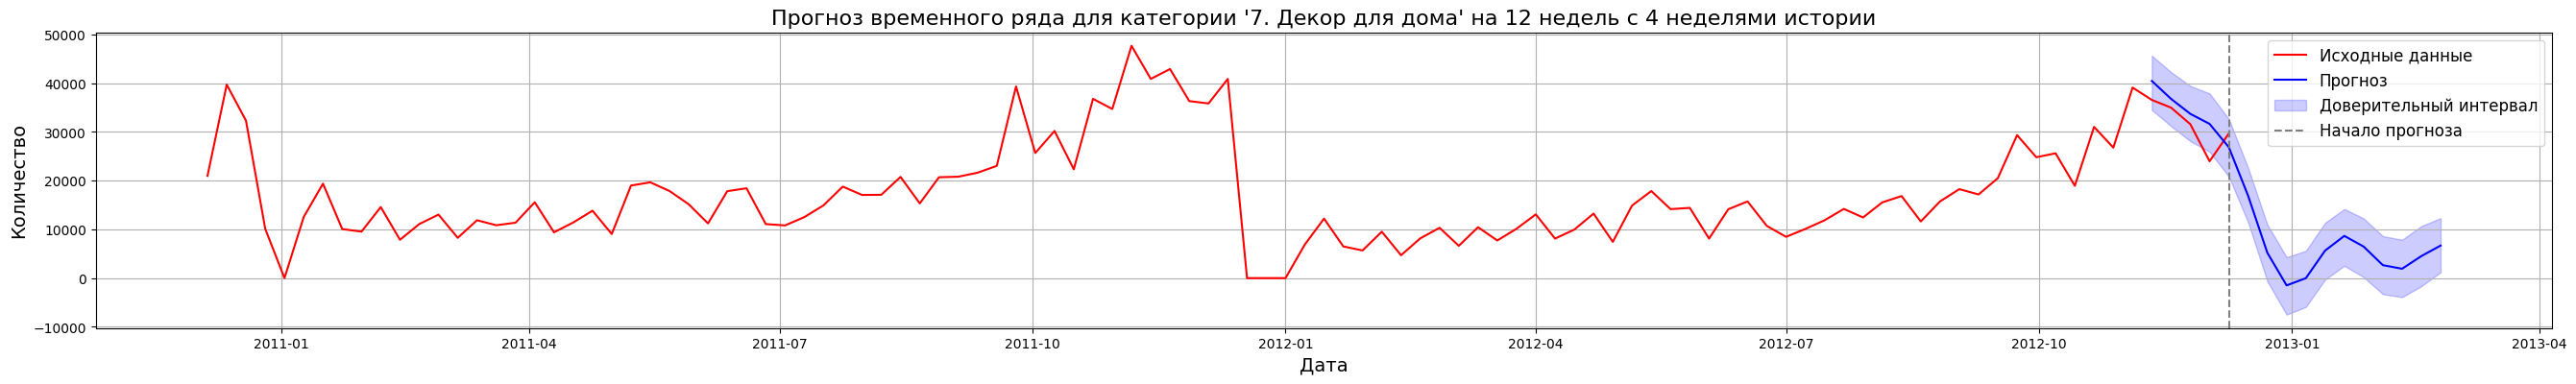



Категория: 6. Свечи и освещение


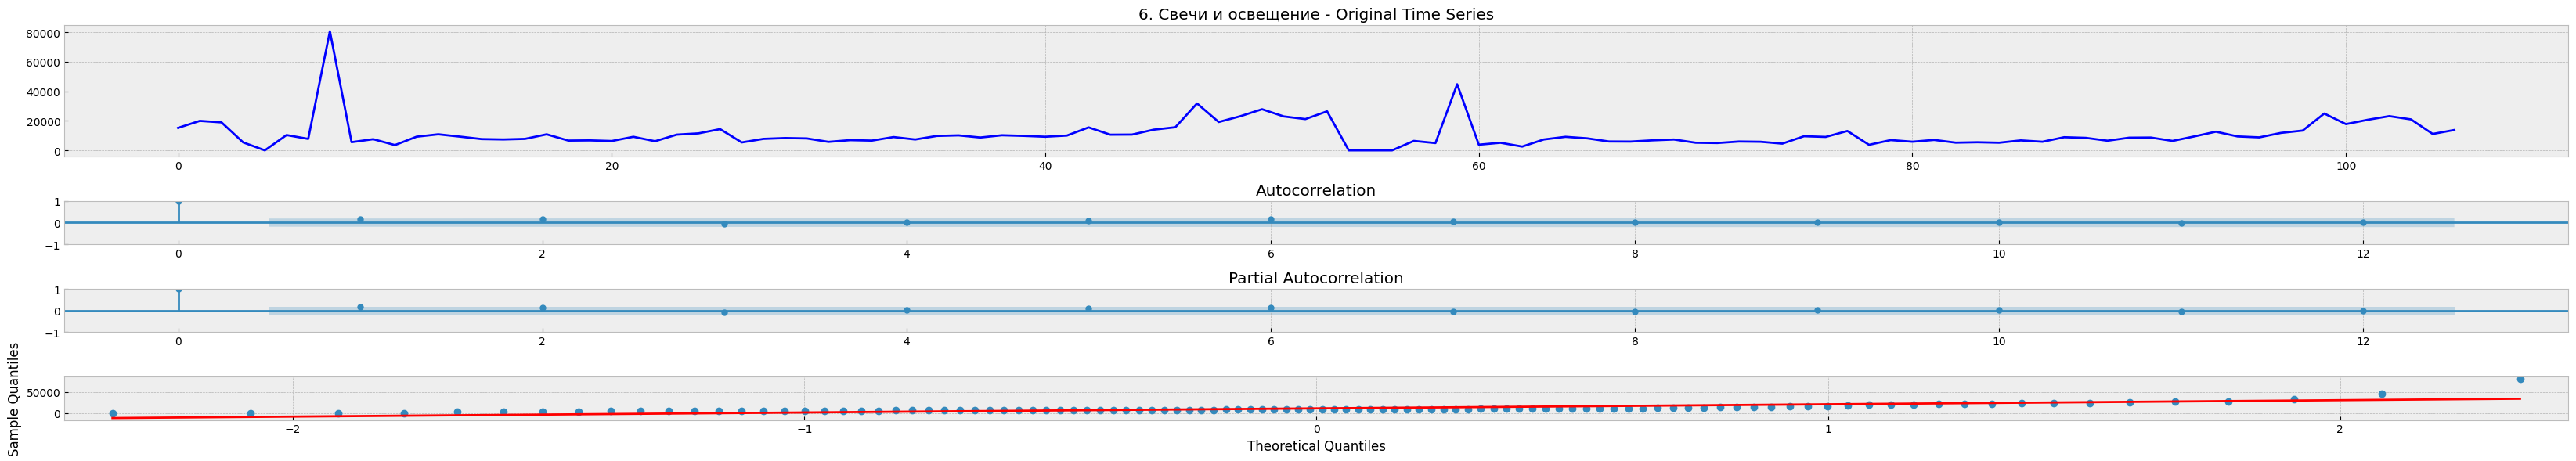

02:33:39 - cmdstanpy - INFO - Chain [1] start processing
02:33:39 - cmdstanpy - INFO - Chain [1] done processing


Категория - 6. Свечи и освещение
Лучший MSE: 10424863.82904, MAE: 2461.91623, R²: 0.68574, MAPE: 19.53%


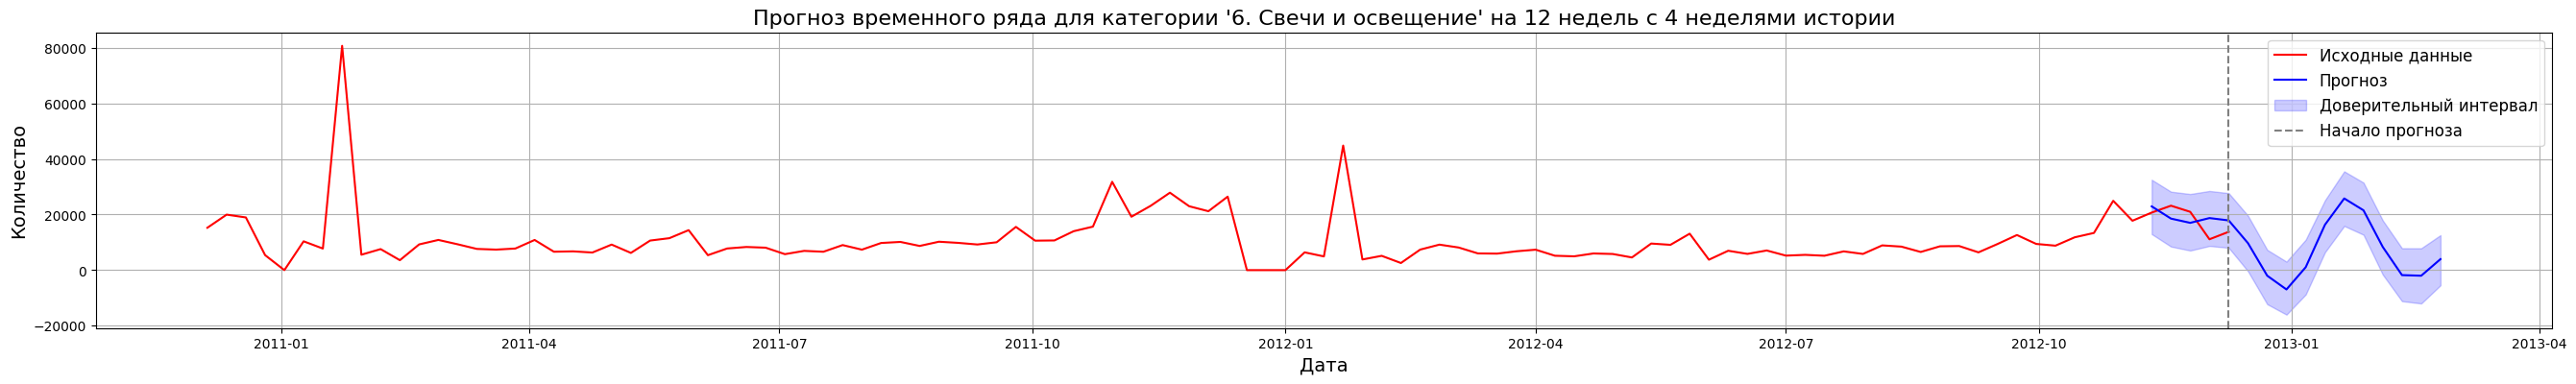



Категория: 4. Кухонные аксессуары и посуда


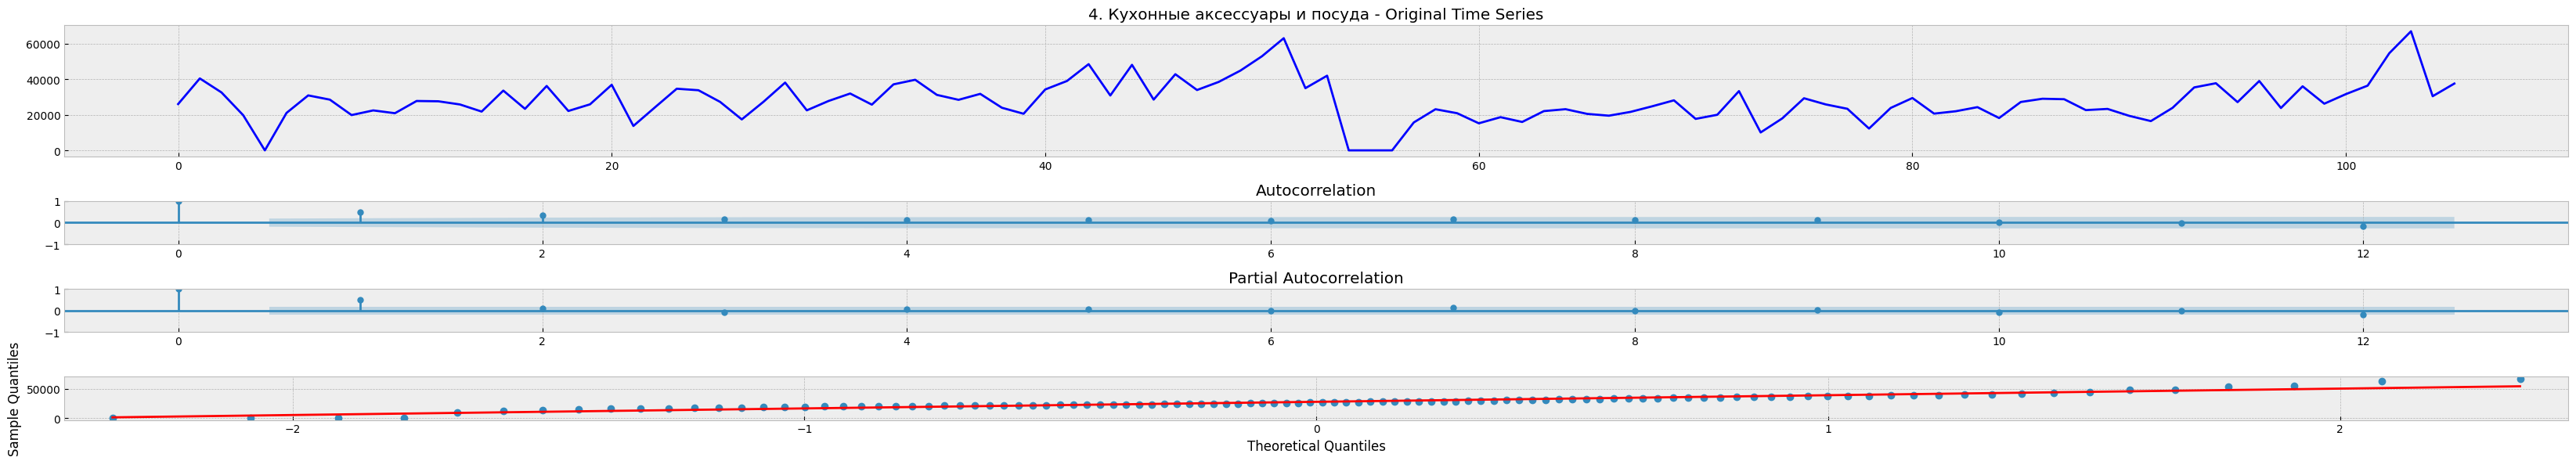

02:33:40 - cmdstanpy - INFO - Chain [1] start processing
02:33:40 - cmdstanpy - INFO - Chain [1] done processing


Категория - 4. Кухонные аксессуары и посуда
Лучший MSE: 50428579.16701, MAE: 5424.22195, R²: 0.61381, MAPE: 16.78%


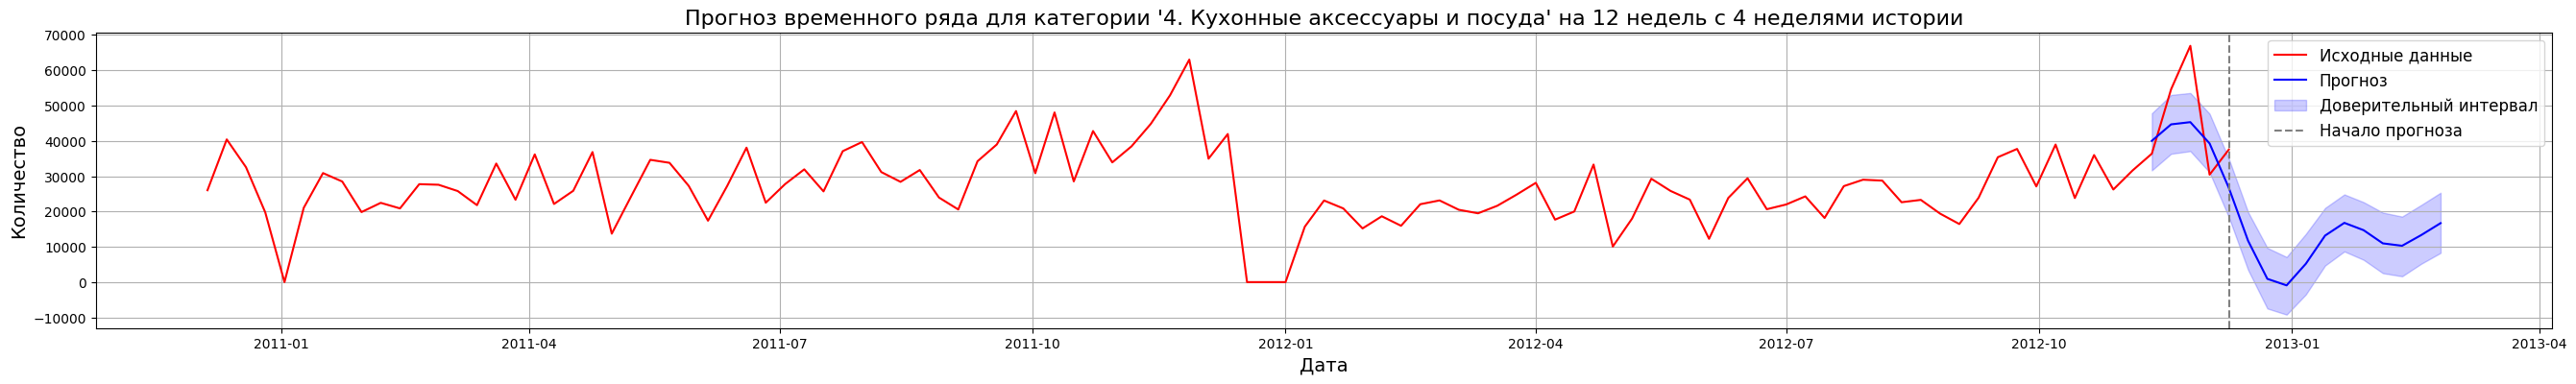



Категория: 2. Стеклянные и керамические аксессуары (оформление интерьера)


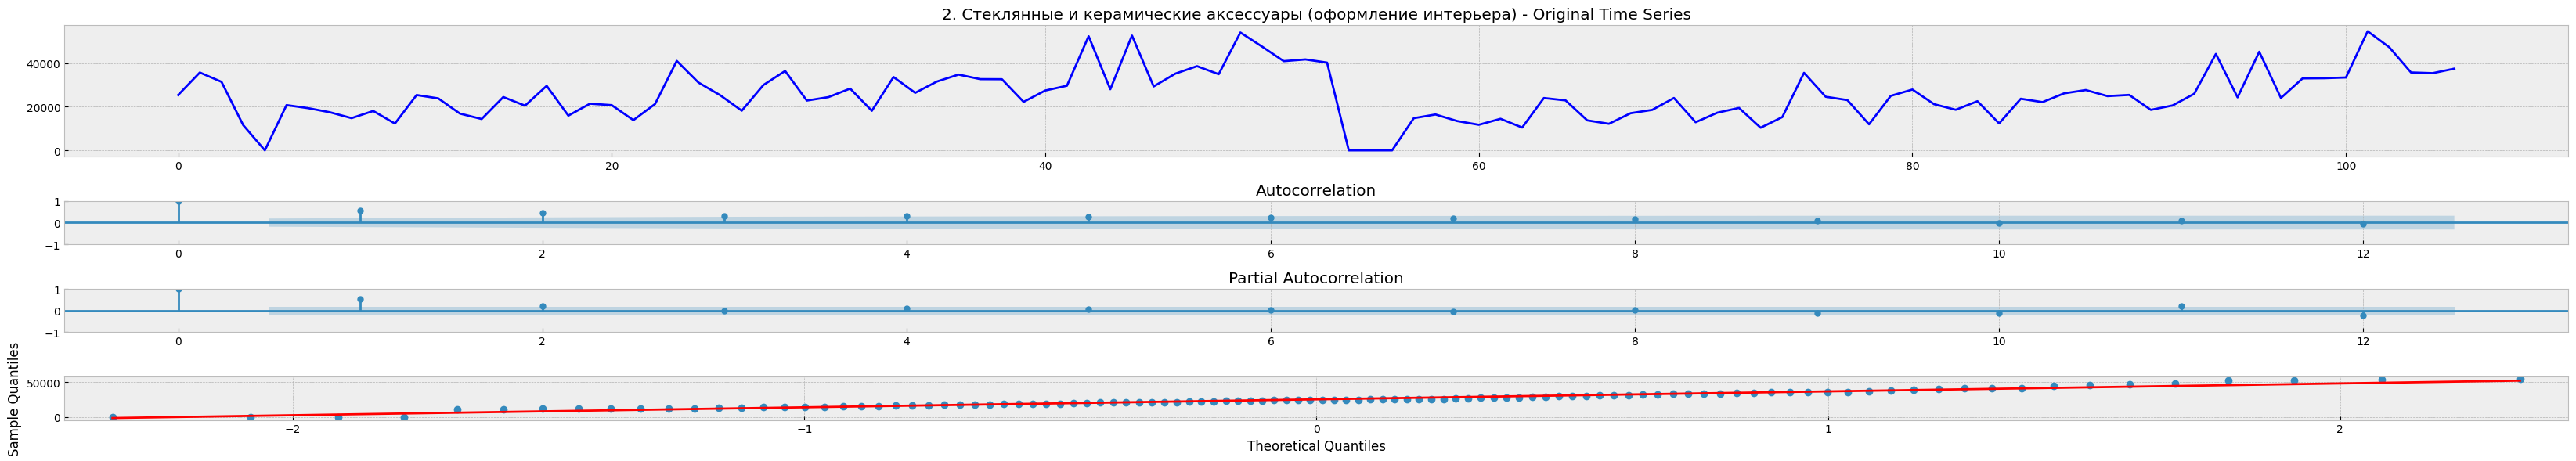

02:33:40 - cmdstanpy - INFO - Chain [1] start processing
02:33:41 - cmdstanpy - INFO - Chain [1] done processing


Категория - 2. Стеклянные и керамические аксессуары (оформление интерьера)
Лучший MSE: 41708817.13495, MAE: 5011.73094, R²: 0.59337, MAPE: 17.61%


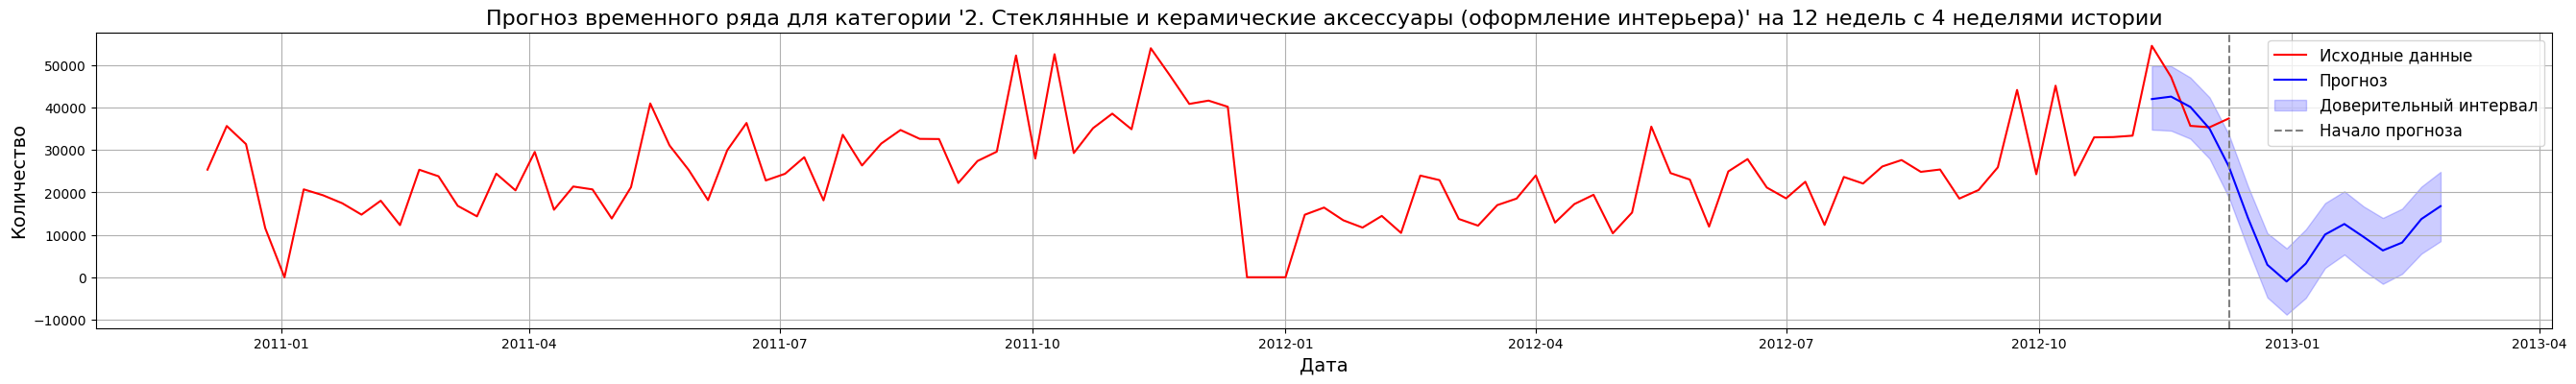



Категория: 8. Праздничные украшения


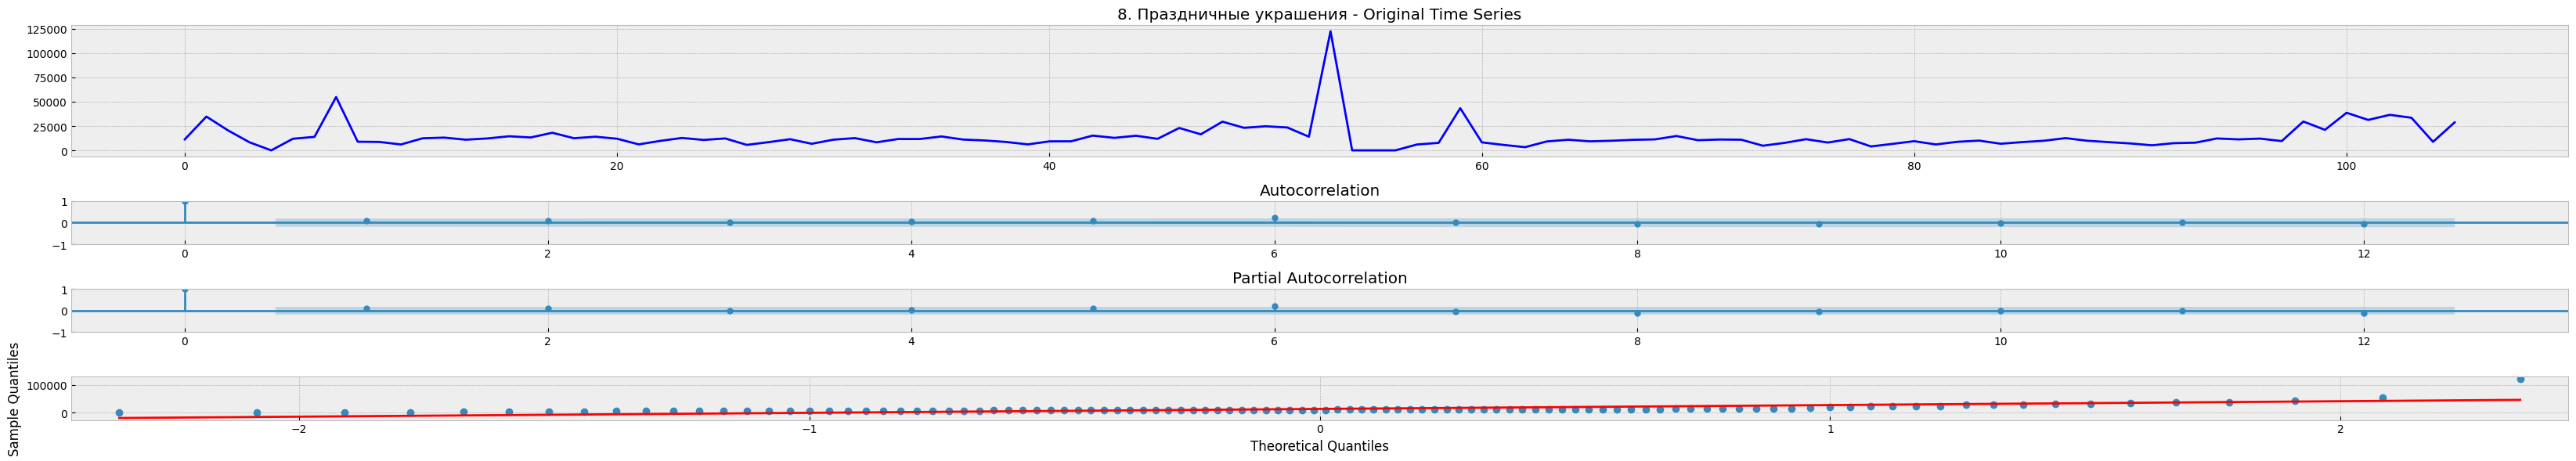

02:33:41 - cmdstanpy - INFO - Chain [1] start processing
02:33:42 - cmdstanpy - INFO - Chain [1] done processing


Категория - 8. Праздничные украшения
Лучший MSE: 90209176.81129, MAE: 6682.85067, R²: 0.23991, MAPE: 44.25%


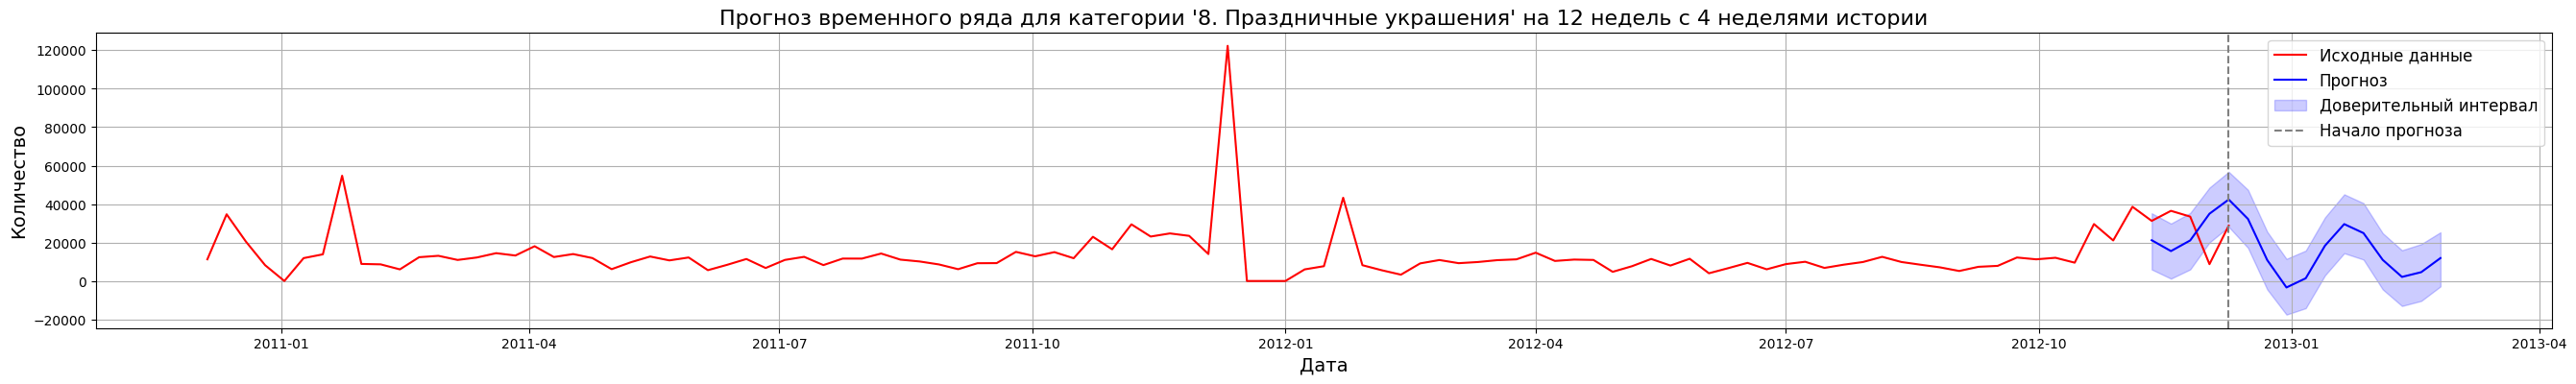



Категория: 1. Стилизованные вещи интерьера с уникальным дизайном


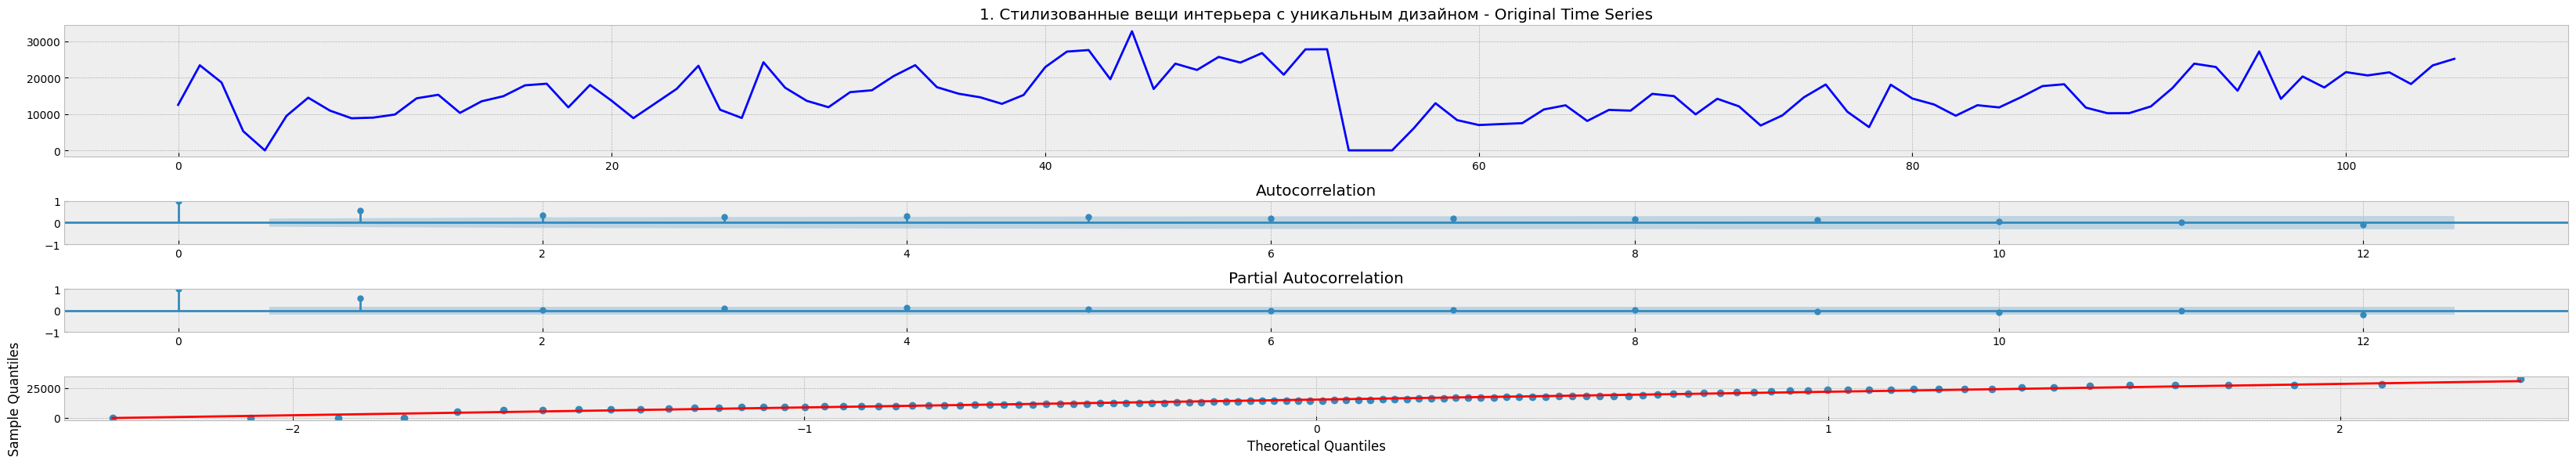

02:33:42 - cmdstanpy - INFO - Chain [1] start processing
02:33:43 - cmdstanpy - INFO - Chain [1] done processing


Категория - 1. Стилизованные вещи интерьера с уникальным дизайном
Лучший MSE: 11633662.61878, MAE: 2532.39643, R²: 0.51289, MAPE: 14.29%


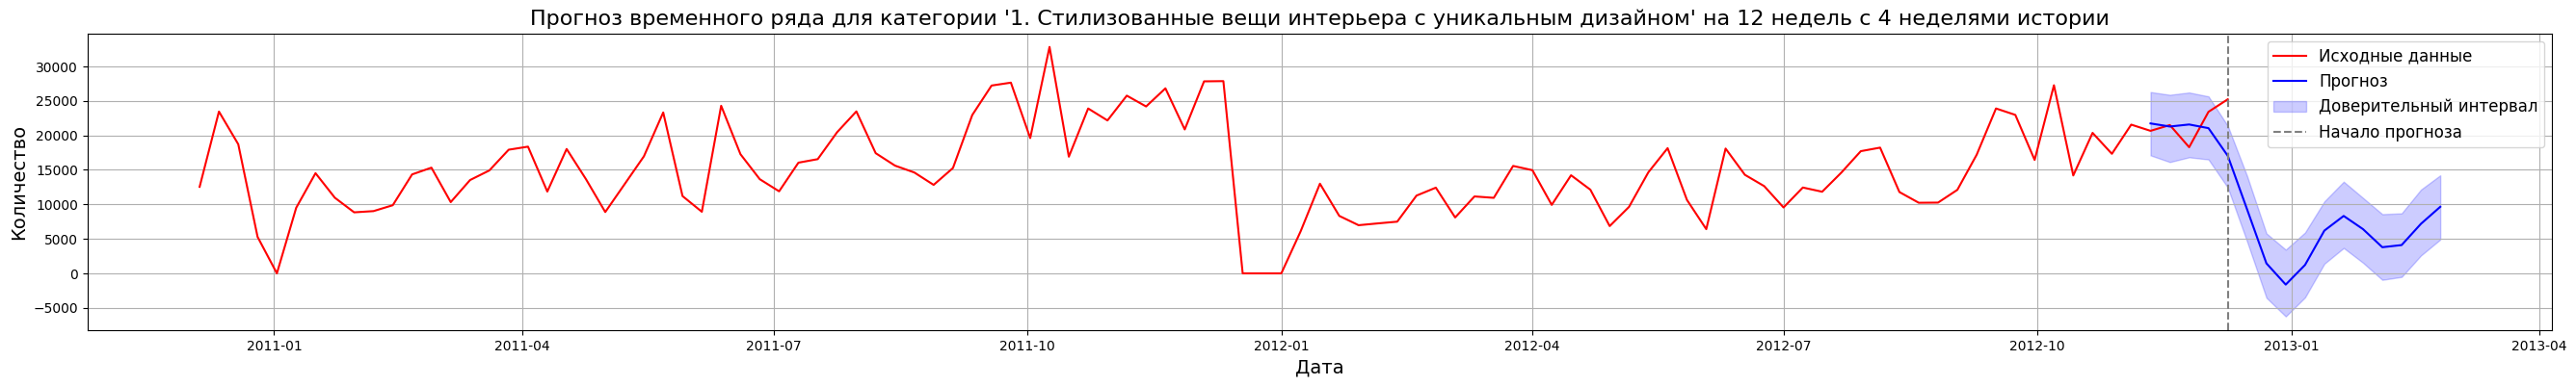



Категория: 5. Игрушки или детские товары


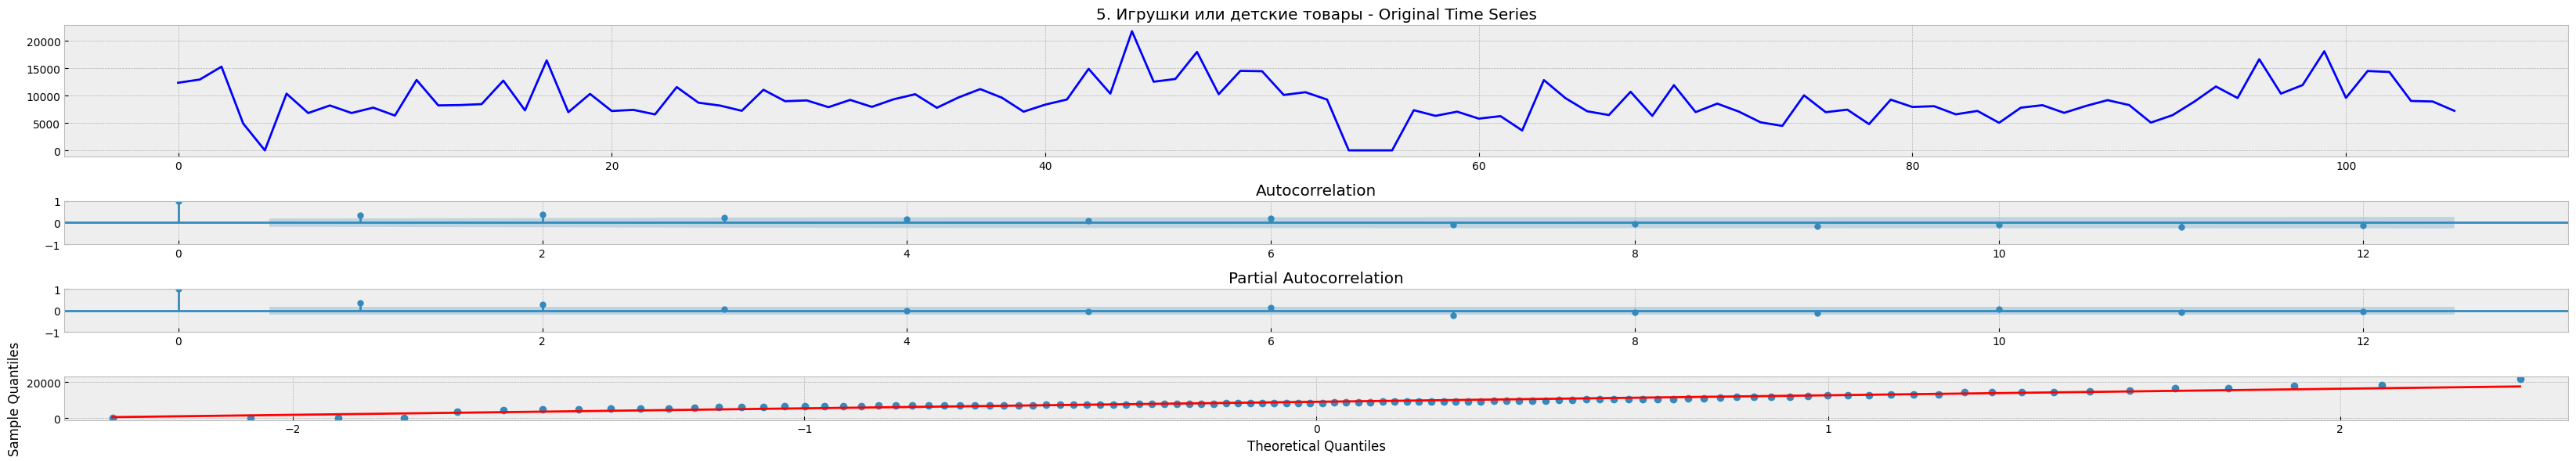

02:33:44 - cmdstanpy - INFO - Chain [1] start processing
02:33:44 - cmdstanpy - INFO - Chain [1] done processing


Категория - 5. Игрушки или детские товары
Лучший MSE: 4998497.96486, MAE: 1749.36612, R²: 0.56511, MAPE: 16.97%


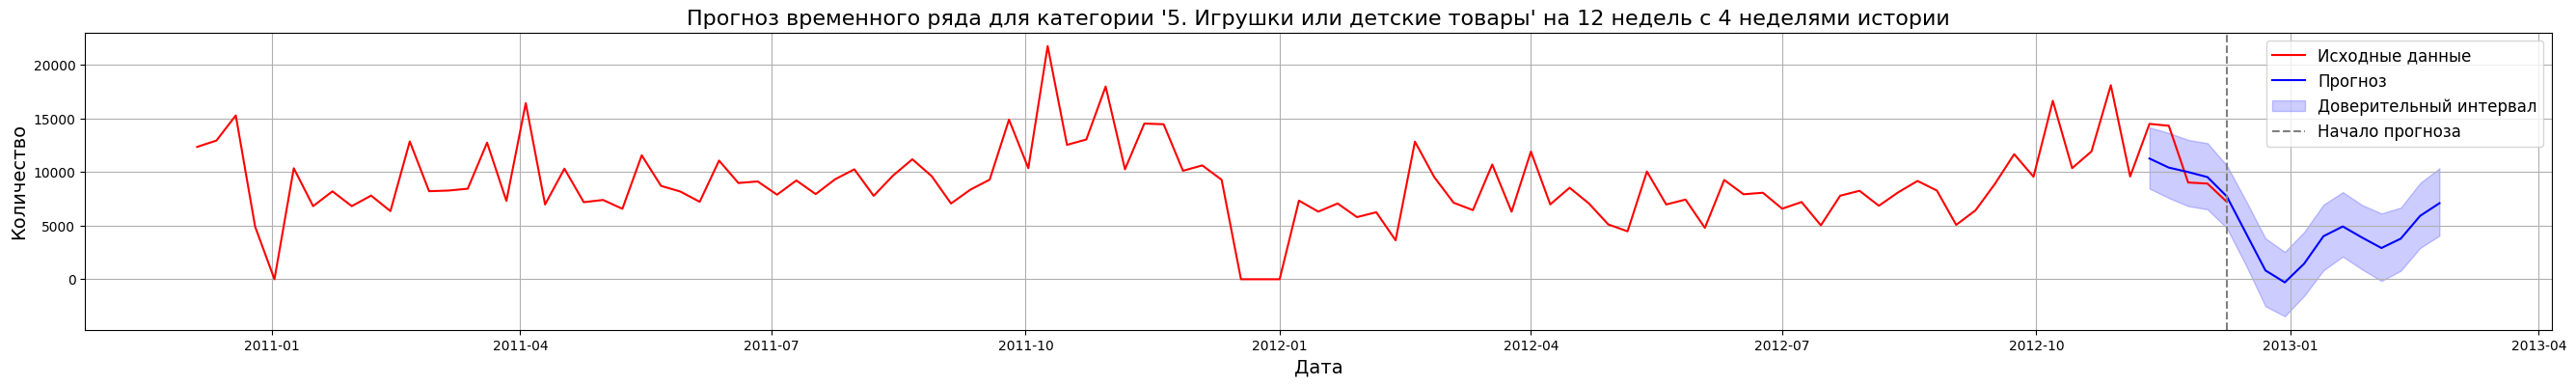



Категория: 9. Браслеты бижутерия


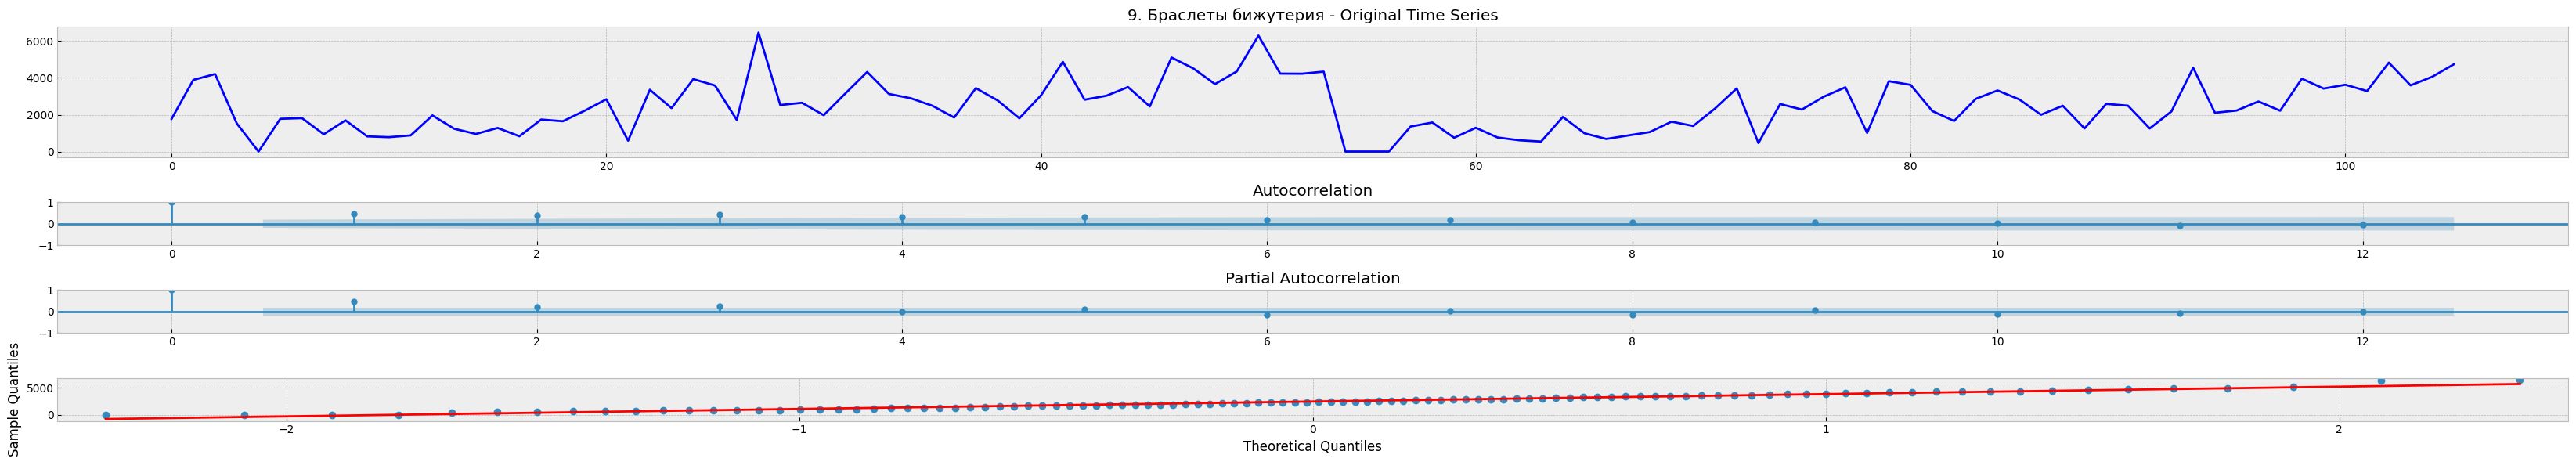

02:33:45 - cmdstanpy - INFO - Chain [1] start processing
02:33:45 - cmdstanpy - INFO - Chain [1] done processing


Категория - 9. Браслеты бижутерия
Лучший MSE: 709302.45996, MAE: 724.80956, R²: 0.30688, MAPE: 28.45%


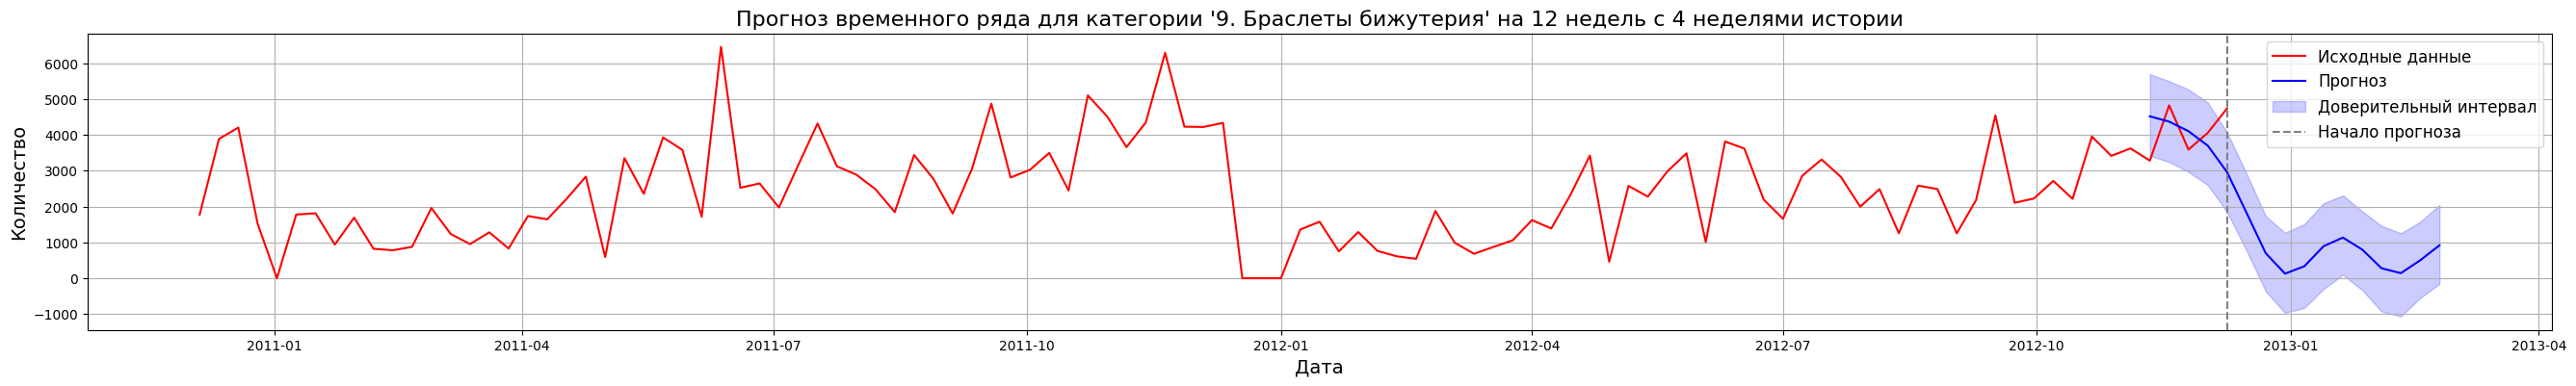



Категория: 3. Часы и рождественские украшения


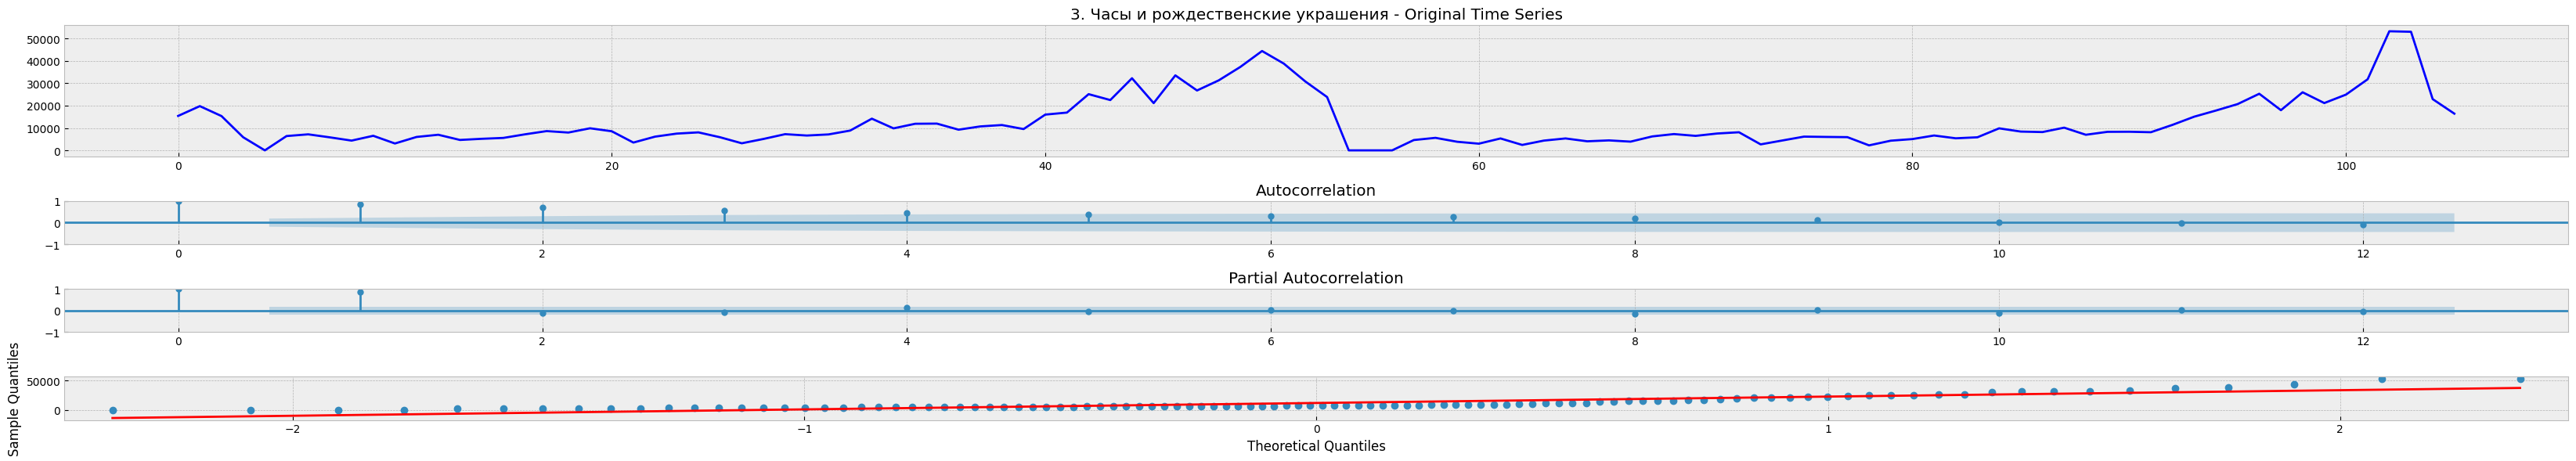

02:33:46 - cmdstanpy - INFO - Chain [1] start processing
02:33:46 - cmdstanpy - INFO - Chain [1] done processing


Категория - 3. Часы и рождественские украшения
Лучший MSE: 31085967.95249, MAE: 3750.65587, R²: 0.81026, MAPE: 17.87%


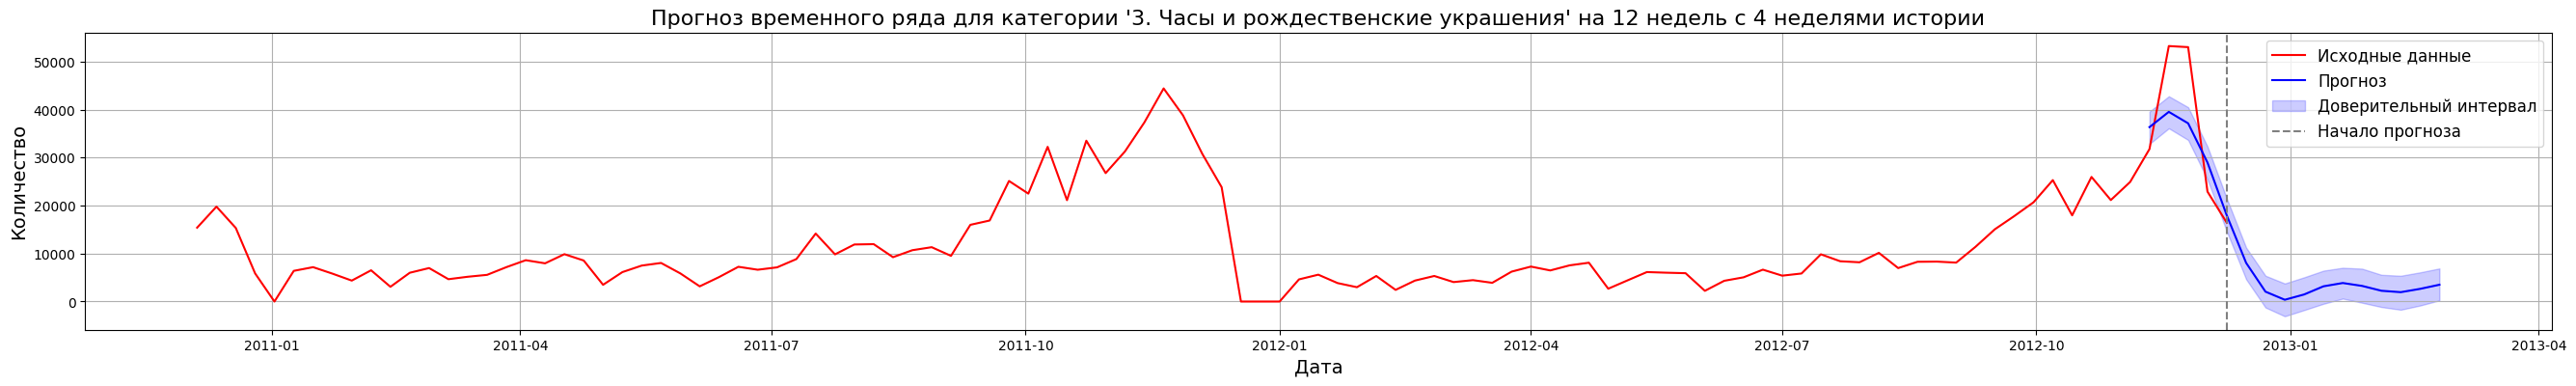



Категория: 11. Прочие


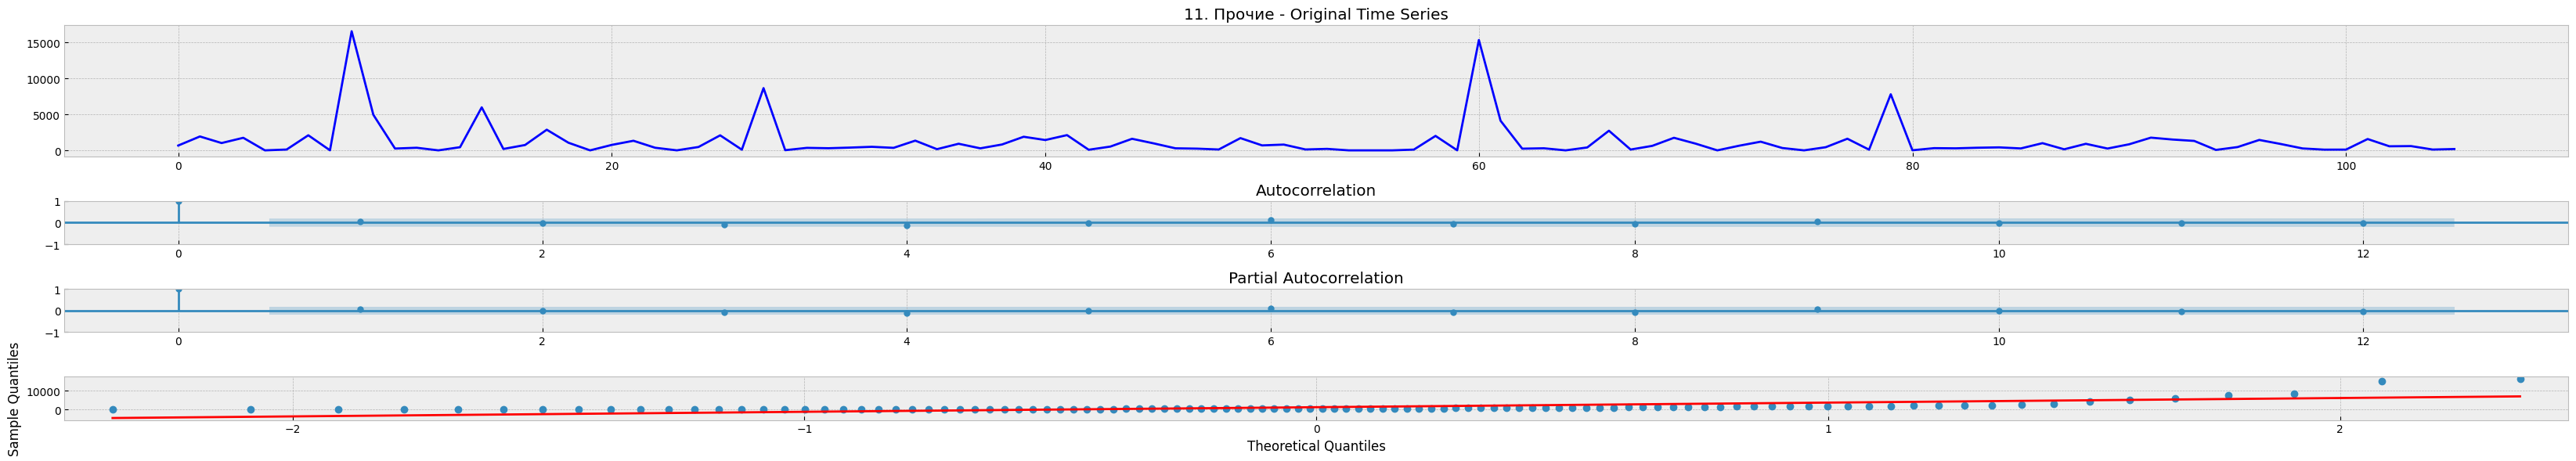

02:33:46 - cmdstanpy - INFO - Chain [1] start processing
02:33:47 - cmdstanpy - INFO - Chain [1] done processing


Категория - 11. Прочие
Лучший MSE: 296873.21333, MAE: 404.48178, R²: -0.01473, MAPE: 132.91%


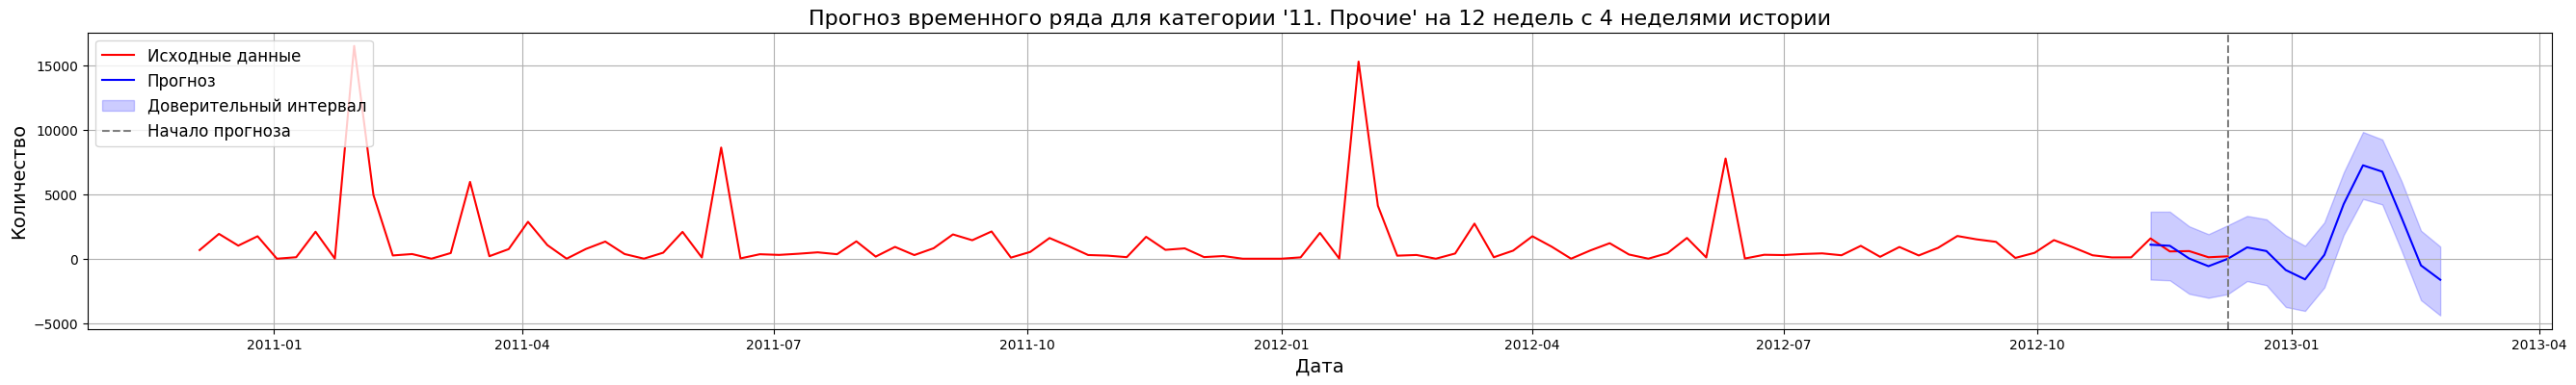

In [27]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm

df_with_category['Дата'] = pd.to_datetime(df_with_category['InvoiceDate'])
categories = df_with_category['category_name'].unique()

def tsplot(name, y, lags=None, figsize=(33, 6), style='bmh'):
    """ Функция для построения временного ряда и графиков автокорреляции. """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Original')
        ts_ax.set_title(name)

        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
        plt.show()

def evaluate_prophet_model(model, test):
    """ Оценка модели Prophet. """
    future = pd.DataFrame({'ds': pd.date_range(start=test['ds'].iloc[0], periods=len(test), freq='W')})
    forecast = model.predict(future)
    
    predictions = forecast['yhat'].values
    mse = mean_squared_error(test['y'], predictions)
    mae = mean_absolute_error(test['y'], predictions)
    r2 = r2_score(test['y'], predictions)
    
    return mse, mae, r2

def mean_absolute_percentage_error(y_true, y_pred):
    """ Средняя абсолютная процентная ошибка (MAPE). """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

for category in categories:
    if pd.isna(category):
        continue
    print(f"\n\nКатегория: {category}")
    
    filtered_sales_data = df_with_category[
        (df_with_category['category_name'] == category)
    ]
    
    sales_data = filtered_sales_data.groupby('Дата')['Quantity'].sum()
    monthly_sales = sales_data.resample('W').sum().reset_index()
    monthly_sales.columns = ['ds', 'y']
    monthly_sales['ds'] = pd.to_datetime(monthly_sales['ds'])
    monthly_sales['y'] = pd.to_numeric(monthly_sales['y'], errors='coerce')
    
    if len(monthly_sales) == 0:
        print(f"Нет данных для категории '{category}'.")
        continue
    train_size = int(len(monthly_sales) * 0.8)
    train, test = monthly_sales[:train_size], monthly_sales[train_size:]
    tsplot(name=f'{category} - Original Time Series', y=monthly_sales['y'], lags=12)
    
    best_mse = np.inf
    best_mae = np.inf
    best_r2 = -np.inf
    best_model = None
    
    seasonality_settings = {'yearly': True, 'weekly': True, 'daily': False}
    
    try:
        model = Prophet(yearly_seasonality=seasonality_settings['yearly'],
                        weekly_seasonality=seasonality_settings['weekly'],
                        daily_seasonality=seasonality_settings['daily'])
        model.fit(train)
        
        mse, mae, r2 = evaluate_prophet_model(model, test)
        mape = mean_absolute_percentage_error(test['y'], model.predict(pd.DataFrame({'ds': test['ds']}))['yhat'].values)
        
        if (mse < best_mse or
            (mse == best_mse and mae < best_mae) or
            (mse == best_mse and mae == best_mae and r2 > best_r2)):
            best_mse = mse
            best_mae = mae
            best_r2 = r2
            best_mape = mape
            best_model = model
    except Exception as e:
        print(f"Ошибка при создании модели для категории '{category}': {e}")
    
    if best_model is not None:
        print('Категория - {}'.format(category))
        print('Лучший MSE: {:.5f}, MAE: {:.5f}, R²: {:.5f}, MAPE: {:.2f}%'.format(best_mse, best_mae, best_r2, best_mape))

        forecast_steps = 12
        history_steps = 4
        
        future = pd.DataFrame({'ds': pd.date_range(start=monthly_sales['ds'].max() - pd.DateOffset(weeks=history_steps), 
                                                  periods=history_steps + forecast_steps, freq='W')})
        forecast = best_model.predict(future)
        forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds')
        
        plt.figure(figsize=(33, 4))
        ax = plt.gca()
        
        plt.plot(monthly_sales['ds'], monthly_sales['y'], color='red', label='Исходные данные')
        
        plt.plot(forecast_df.index, forecast_df['yhat'], color='blue', label='Прогноз')
        plt.fill_between(forecast_df.index, forecast_df['yhat_lower'], forecast_df['yhat_upper'], color='blue', alpha=0.2, label='Доверительный интервал')
        
        plt.axvline(x=monthly_sales['ds'].max(), color='grey', linestyle='--', label='Начало прогноза')
        plt.title(f"Прогноз временного ряда для категории '{category}' на {forecast_steps} недель с {history_steps} неделями истории", fontsize=16)
        plt.xlabel('Дата', fontsize=14)
        plt.ylabel('Количество', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.show()
    else:
        print(f"Не удалось создать модель для категории '{category}'")
